In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

# import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
# from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
# from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
# import xitorch
# from xitorch.linalg import symeig

from glob import glob

from scipy.linalg import eigvalsh
from pathlib import Path
# from mlelec.utils.pbc_utils import  TMap_bloch_sums_feat
plt.rcParams['figure.figsize'] = 2*1.618, 2
plt.rcParams['figure.dpi'] = 300

In [1]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
def compute_eigenvalues(blocks, dataset, overlap_matrices = None, baseline = None, Hk=False):
    if not Hk:
        recon_HT = blocks_to_matrix(blocks, dataset, detach = True)
        recon_Hk = dataset.bloch_sum(recon_HT)
    else: 
        recon_Hk = kblocks_to_matrix(_to_uncoupled_basis(blocks), dataset)
    if baseline is not None:
        for Hks, H0ks in zip(recon_Hk, baseline):
            for Hk, H0k in zip(Hks, H0ks):
                Hk += H0k
    
    if overlap_matrices is not None:
        recon_Sk = overlap_matrices
        # recon_ST = blocks_to_matrix(overlap_blocks, dataset)
        # recon_Sk = dataset.bloch_sum(recon_ST)
        is_ortho = False
    else:
        is_ortho = True
        
    eigvals = []
    if is_ortho:
        for Hk in recon_Hk:
            ek = []
            for h in Hk:
                ek.append(eigvalsh(h.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
    else:
        for i, (Hk, Sk) in enumerate(zip(recon_Hk, recon_Sk)):
            ek = []
                
            for h, s in zip(Hk, Sk):
                ek.append(eigvalsh(h.detach().cpu().numpy(), b = s.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
            
    return np.stack(eigvals), torch.stack(recon_Hk)

def rmse_vector(v1, v2):
    return np.sqrt(np.mean(np.abs(v1-v2)**2))

def mae_vector(v1, v2):
    return np.mean(np.abs(v1 - v2))

In [6]:
root = '/scratch/pegolo/seed_73/'
nhidden = 64
nlayers = 1
device = 'cpu'
cutoff = 8
overwrite = True

results_dir = f'{root}/test_results'
Path(results_dir).mkdir(exist_ok = overwrite)

orbitals = {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}
orbital_names = 'sto-3g'

kmesh = [8,8,1]

In [7]:
START, STOP = 0, 140

indices = np.loadtxt(f'{root}/random_indices.txt', dtype = int)[START:STOP]
frames = [read(f'{root}/test/C2_174.extxyz', index = i) for i in indices]
rfock = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/test/data/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

for f in frames:
    f.pbc=[True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc=True

dataset = QMDataset(frames = frames,
                               kmesh = kmesh,
                               dimension = 2,
                               fock_realspace = rfock,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals,
                               orbs_name = orbital_names)

dataset0 = QMDataset(frames = frames,
                               kmesh = kmesh,
                               dimension = 2,
                               fock_realspace = rfock0,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals,
                               orbs_name = orbital_names)

_, HT_blocks = get_targets(dataset, cutoff = 8)
train_target_matrices = dataset.bloch_sum(blocks_to_matrix(HT_blocks, dataset)) 

_, overlap_blocks = get_targets(dataset, cutoff = 8, target = 'overlap')
train_overlap_matrices = dataset.bloch_sum(blocks_to_matrix(overlap_blocks, dataset)) 

_, baseline_blocks = get_targets(dataset0, cutoff = 8)
train_baseline_target = dataset.bloch_sum(blocks_to_matrix(baseline_blocks, dataset0))
# train_baseline_blocks_k = kmatrix_to_blocks(dataset0, cutoff = 8, matrix = train_baseline_target)

In [9]:
# Features
train_features = {}
train_features_new={}
train_targets = {}
train_targets_k = {}
train_datasets = {}
train_baseline = {}
for i in range(20, 141, 20):
    features = []
    for _i in range(0, i, 20):
        print(i, _i, _i+20)
        features.append(mts.load(f'{root}/features/features_{_i}_{_i+20}_seed73'))
    if len(features) == 1:
        train_features[i] = features[0]
    else:
        features = mts.join(features, axis = 'samples')
        blocks = []
        for k, b in features.items():
            sample_values = b.samples.values
            sample_values[:, 0] += sample_values[:, 6]*20
            samples = mts.Labels(b.samples.names[:-1], sample_values[:, :-1])
            blocks.append(mts.TensorBlock(
            values = b.values,
            samples = samples,
            properties = b.properties,
            components = b.components
            ))
        train_features[i] = mts.TensorMap(features.keys, blocks)

    # train_features[i] = mts.load(f'{root}/features/features_{i-20}_{i}_seed73')


    # ds = QMDataset(
    #                             frames = frames[i-20:i],
    #                            kmesh = kmesh,
    #                            dimension = 2,
    #                            fock_realspace = rfock[i-20:i],
    #                            overlap_realspace = rover[i-20:i],
    #                            device = device,
    #                            orbs = orbitals,
    #                            orbs_name = orbital_names)
    ds = QMDataset(
                                frames = frames[:i],
                               kmesh = kmesh,
                               dimension = 2,
                               fock_realspace = rfock[:i],
                               overlap_realspace = rover[:i],
                               device = device,
                               orbs = orbitals,
                               orbs_name = orbital_names)
    train_datasets[i] = ds
    _, train_targets[i] = get_targets(ds, cutoff = 8)
    phase, indices ,_= precompute_phase(train_targets[i], ds)
    train_targets_k[i] = TMap_bloch_sums(train_targets[i], phase, indices, _, return_tensormap=True)
    
    train_features_new[i] = mts.load(f'{root}/features/features_new1106/features_{i-20}_{i}_seed73')
    # features = []
    # for _i in range(0, i, 20):
    #     print('new', i, _i, _i+20)
    #     features.append(mts.load(f'{root}/features/features_new1106/features_{_i}_{_i+20}_seed73'))
    # if len(features) == 1:
    #     train_features_new[i] = features[0]
    # else:
    #     features = mts.join(features, axis = 'samples')
    #     blocks = []
    #     for k, b in features.items():
    #         sample_values = b.samples.values
    #         sample_values[:, 0] += sample_values[:, 6]*20
    #         samples = mts.Labels(b.samples.names[:-1], sample_values[:, :-1])
    #         blocks.append(mts.TensorBlock(
    #         values = b.values,
    #         samples = samples,
    #         properties = b.properties,
    #         components = b.components
    #         ))
    #     train_features_new[i] = mts.TensorMap(features.keys, blocks)

    # phase, indices ,_= precompute_phase(train_features_new[i], ds)
    # train_features_new[i] = TMap_bloch_sums_feat(train_features_new[i], phase, indices, _, return_tensormap=True)

    

20 0 20
40 0 20
40 20 40
60 0 20
60 20 40
60 40 60
80 0 20
80 20 40
80 40 60
80 60 80
100 0 20
100 20 40
100 40 60
100 60 80
100 80 100
120 0 20
120 20 40
120 40 60
120 60 80
120 80 100
120 100 120
140 0 20
140 20 40
140 40 60
140 60 80
140 80 100
140 100 120
140 120 140


In [10]:
# Load test set features
test_features = mts.load(f'{root}/test/features_140_172_seed73')

# Define dataset
START, STOP = 140, 172
indices = np.loadtxt(f'{root}/random_indices.txt', dtype = int)[START:STOP]
frames = [read(f'{root}/test/C2_174.extxyz', index = i) for i in indices]
rfock = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/test/data/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

for f in frames:
    f.pbc=[True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc=True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] -= K0[T]

dataset = QMDataset(frames = frames,
                               kmesh = kmesh,
                               dimension = 2,
                               fock_realspace = rfock,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals,
                               orbs_name = orbital_names)

dataset0 = QMDataset(frames = frames,
                               kmesh = kmesh,
                               dimension = 2,
                               fock_realspace = rfock0,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals,
                               orbs_name = orbital_names)

# overlap_matrices = dataset.bloch_sum(blocks_to_matrix(mts.load(f'{root}/test/overlap_coupled_blocks'), dataset)) 
# test_HT_blocks = mts.load(f'{root}/test/target_coupled_blocks')
# baseline_blocks = mts.load(f'{root}/test/target_coupled_blocks0')
_, test_HT_blocks = get_targets(dataset, cutoff = 8)
phase, indices ,_= precompute_phase(test_HT_blocks, dataset)
test_HT_blocks_k = TMap_bloch_sums(test_HT_blocks, phase, indices, _, return_tensormap=True)

_, overlap_blocks = get_targets(dataset, cutoff = 8, target = 'overlap')
overlap_matrices = dataset.bloch_sum(blocks_to_matrix(overlap_blocks, dataset)) 

_, baseline_blocks = get_targets(dataset0, cutoff = 8)
baseline_target = dataset.bloch_sum(blocks_to_matrix(baseline_blocks, dataset0))
# baseline_blocks_k = kmatrix_to_blocks(dataset0, cutoff = cutoff, matrix = baseline_target)

test_features_new = mts.load(f'{root}/test/features_140_172_seed73_new')

# phase, indices ,_= precompute_phase(test_features_new, dataset)
# test_features_new = TMap_bloch_sums_feat(test_features_new, phase, indices, _, return_tensormap=True)

In [11]:

target_eigvals, target_matrices = compute_eigenvalues(test_HT_blocks, dataset, overlap_matrices = overlap_matrices)

# TORCH 

In [12]:
# Initialize model
model = LinearModelPeriodic(twocfeat = test_features, 
                             target_blocks = test_HT_blocks,
                             frames = dataset.structures, orbitals = dataset.basis, 
                             device = device,
                             bias = True,
                             nhidden = nhidden, 
                             nlayers = nlayers,
                             activation = 'SiLU',
                             apply_norm = True)
model = model.double()

In [14]:
# Compute metrics

RMSE = {}
MAE = {}
STD = {}

RMSE_train = {}
MAE_train = {}
STD_train = {}

for space in ['real_space', 'kspace']:

    RMSE[space] = {}
    MAE[space] = {}
    STD[space] = {}

    RMSE_train[space] = {}
    MAE_train[space] = {}
    STD_train[space] = {}

    folders = glob(f'{root}/benchmarks/{space}/*')

    for folder in folders:
        
        fname = folder.split('/')[-1]

        RMSE[space][fname] = {}
        MAE[space][fname] = {}
        STD[space][fname] = {}

        RMSE_train[space][fname] = {}
        MAE_train[space][fname] = {}
        STD_train[space][fname] = {}

        if 'baseline' in fname.split('_') or 'traceless' in fname.split('_'):
            is_baseline = True
        else:
            is_baseline = False

        if 'orthogonalized' in fname.split('_'):
            is_ortho = True
        else:
            is_ortho = False

        print(f'Analyzing {fname}. is_baseline = {is_baseline}; is_ortho = {is_ortho}', flush = True)

        if is_ortho:
            overlap_mat = None
        else:
            overlap_mat = overlap_matrices

        if is_baseline:
            baseline = baseline_target
        else:
            baseline = None
        
        # Load trained models
        checkpoint = {}
        train_folders = glob(f'{folder}/train_*')
        for train_folder in train_folders:
            
            nstruc = int(train_folder.split('/')[-1].split('_')[2])
            
            print(f'    {nstruc} {train_folder}')

            ckpts = glob(f'{train_folder}/*ckpt')
            if len(ckpts):
                
                RMSE[space][fname][nstruc] = {}
                MAE[space][fname][nstruc] = {}
                STD[space][fname][nstruc] = {}

                RMSE_train[space][fname][nstruc] = {}
                MAE_train[space][fname][nstruc] = {}
                STD_train[space][fname][nstruc] = {}
                
                last_model = max([int(ckpt.split('/')[-1].split('.')[0].split('_')[1]) for ckpt in ckpts])
    
                print(f'    {train_folder}: loading model trained over {last_model} epochs', flush = True)
                checkpoint[nstruc] = torch.load(f'{train_folder}/model_{last_model}.ckpt')
                model.load_state_dict(checkpoint[nstruc]['model_state_dict'])

                # Train metrics

                if is_ortho:
                    train_overlap_mat = train_overlap_matrices[0:nstruc]
                else:
                    train_overlap_mat = None

                if is_baseline:
                    train_baseline = train_baseline_target[0:nstruc]
                else:
                    train_baseline = None
                
                pred_HT_blocks = model.predict(train_features[nstruc], train_targets[nstruc])
                pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, train_datasets[nstruc], baseline = train_baseline, overlap_matrices = train_overlap_mat)

                # RMSE_train[space][fname][nstruc]['eigvals'] = rmse_vector(target_eigvals, pred_eigvals)
                RMSE_train[space][fname][nstruc]['fock'] = rmse_vector(torch.stack(train_target_matrices[0:nstruc]).numpy(), pred_Hk.numpy())
                # MAE_train[space][fname][nstruc]['eigvals'] = mae_vector(target_eigvals, pred_eigvals)
                MAE_train[space][fname][nstruc]['fock'] = mae_vector(torch.stack(train_target_matrices[0:nstruc]).numpy(), pred_Hk.numpy())
                # STD_train[space][fname][nstruc]['eigvals'] = target_eigvals.flatten().std()
                STD_train[space][fname][nstruc]['fock'] = torch.stack(train_target_matrices[0:nstruc]).numpy().std()
               
                # Test metrics
                pred_HT_blocks = model.predict(test_features, test_HT_blocks)
                pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, dataset, baseline = baseline, overlap_matrices = overlap_mat)
    
                eig_dict = {'target': target_eigvals, 'prediction': pred_eigvals}
                np.save(f'{results_dir}/{fname}_eigenvalues.npy', eig_dict)
                np.save(f'{results_dir}/{fname}_fock.npy', np.array([np.concatenate([target_matrices.numpy().flatten().real,target_matrices.numpy().flatten().imag]),
                                                                     np.concatenate([pred_Hk.numpy().flatten().real,pred_Hk.numpy().flatten().imag])]).T)

                RMSE[space][fname][nstruc]['eigvals'] = rmse_vector(target_eigvals, pred_eigvals)
                RMSE[space][fname][nstruc]['fock'] = rmse_vector(target_matrices.numpy(), pred_Hk.numpy())
                MAE[space][fname][nstruc]['eigvals'] = mae_vector(target_eigvals, pred_eigvals)
                MAE[space][fname][nstruc]['fock'] = mae_vector(target_matrices.numpy(), pred_Hk.numpy())
                STD[space][fname][nstruc]['eigvals'] = target_eigvals.flatten().std()
                STD[space][fname][nstruc]['fock'] = target_matrices.numpy().std()
                
                print(f'    RMSE {fname} {nstruc} eigvals {RMSE[space][fname][nstruc]["eigvals"]}', flush = True)
                print(f'    RMSE {fname} {nstruc} fock {RMSE[space][fname][nstruc]["fock"]}', flush = True)
    
                print(f'    MAE {fname} {nstruc} eigvals {MAE[space][fname][nstruc]["eigvals"]}', flush = True)
                print(f'    MAE {fname} {nstruc} fock {MAE[space][fname][nstruc]["fock"]}', flush = True)
            else:
                print('    Empty folder!')

Analyzing a_direct_HT. is_baseline = False; is_ortho = False
    100 /scratch/pegolo/seed_73/benchmarks/real_space/a_direct_HT/train_0_100
    /scratch/pegolo/seed_73/benchmarks/real_space/a_direct_HT/train_0_100: loading model trained over 950 epochs
    RMSE a_direct_HT 100 eigvals 0.004209612011973678
    RMSE a_direct_HT 100 fock 0.001374892113776048
    MAE a_direct_HT 100 eigvals 0.001860711382555376
    MAE a_direct_HT 100 fock 0.0003370794650897393
    120 /scratch/pegolo/seed_73/benchmarks/real_space/a_direct_HT/train_0_120
    /scratch/pegolo/seed_73/benchmarks/real_space/a_direct_HT/train_0_120: loading model trained over 800 epochs
    RMSE a_direct_HT 120 eigvals 0.003947801969816272
    RMSE a_direct_HT 120 fock 0.00129986155432672
    MAE a_direct_HT 120 eigvals 0.001687742278935664
    MAE a_direct_HT 120 fock 0.00030722171616705474
    140 /scratch/pegolo/seed_73/benchmarks/real_space/a_direct_HT/train_0_140
    /scratch/pegolo/seed_73/benchmarks/real_space/a_direct_HT

Text(0, 0.5, 'Test RMSE (%)')

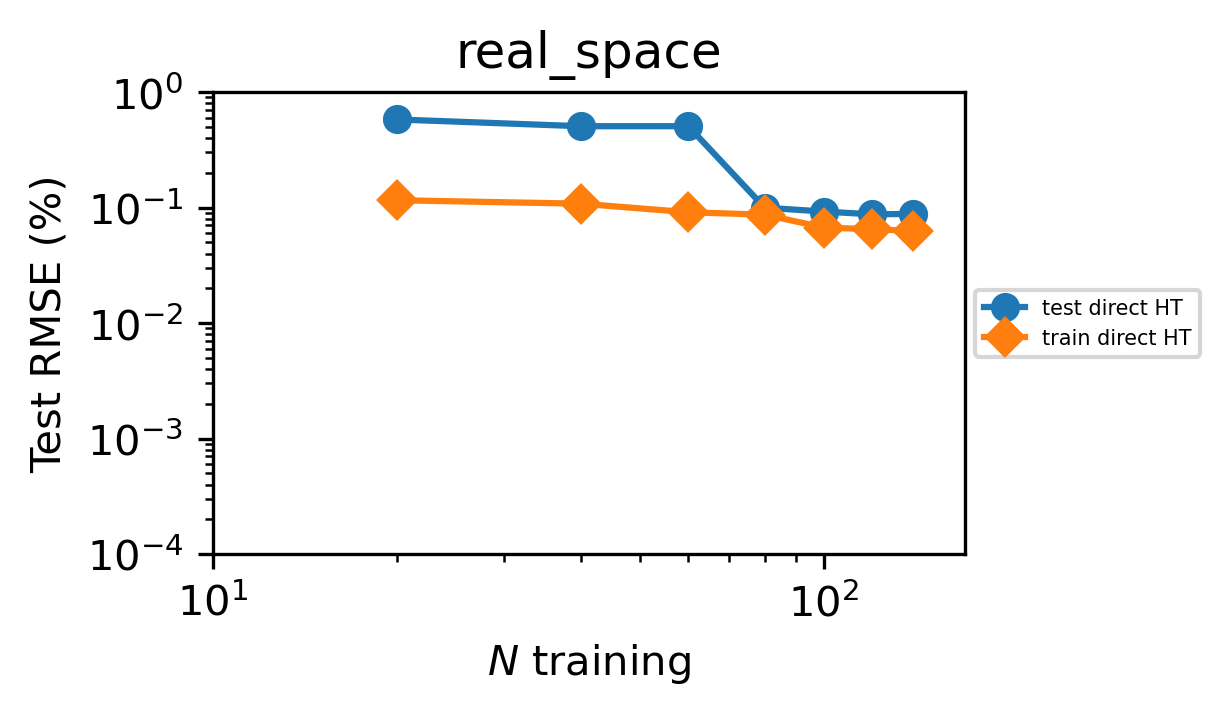

In [15]:
metrics_name = 'RMSE'
target_quantity = 'fock'
is_relative = True


space = 'real_space'

# for strategy in metrics[space]:

strategy = 'a_direct_HT'
fig, ax = plt.subplots()

if metrics_name == 'RMSE':
    metrics = RMSE
    train_metrics = RMSE_train
elif metrics_name == 'MAE':
    metrics = MAE
    train_metrics = MAE_train

# if metrics[space][strategy] == {}:
    # continue
x = np.array([float(n) for n in metrics[space][strategy]])
if is_relative:
    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
    y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
    unit = '%'
    upper = 1
else:
    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
    y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
    unit = 'meV'
    upper = 10*Hartree*1000
y = y[x.argsort()]
y_train = y_train[x.argsort()]
x = x[x.argsort()]
ax.plot(x, y, '-o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
ax.plot(x, y_train, '-D', label = 'train ' + ' '.join(strategy.split("_")[1:]))


# if metrics_name == 'RMSE':
#     metrics = ridge_RMSE
#     train_metrics = ridge_RMSE_train
# elif metrics_name == 'MAE':
#     metrics = ridge_MAE
#     train_metrics = ridge_MAE_train

# strategy += '_ridge'
# # if metrics[space][strategy] == {}:
# #     continue
# x = np.array([float(n) for n in metrics[space][strategy]])
# if is_relative:
#     y = np.array([metrics[space][strategy][n][target_quantity]/ridge_STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
#     y_train = np.array([train_metrics[space][strategy][n][target_quantity]/ridge_STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
#     unit = '%'
#     lower = 1e-6
#     upper = 1
# else:
#     y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
#     y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
#     unit = 'meV'
#     lower = Hartree*1000
#     upper = 10*Hartree*1000
# y = y[x.argsort()]
# y_train = y_train[x.argsort()]
# x = x[x.argsort()]
# pl1,=ax.plot([x[0], x[-1]], [y[0], y[-1]], 'o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
# pl2,=ax.plot([x[0], x[-1]], [y_train[0], y_train[-1]], 'D', label = 'train ' + ' '.join(strategy.split("_")[1:]))

# ax.plot(x, y, '--', lw = 0.5, color = pl1.get_color())
# ax.plot(x, y_train, '--', lw = 0.5, color = pl2.get_color())

ax.legend(fontsize = 5, bbox_to_anchor = (1,0.5), loc = 'center left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 170)
ax.set_ylim(1e-4, 1)
ax.set_xlabel('$N$ training')
ax.set_title(space)
ax.set_ylabel(f'Test {metrics_name} ({unit})')

Text(0, 0.5, 'Test RMSE (%)')

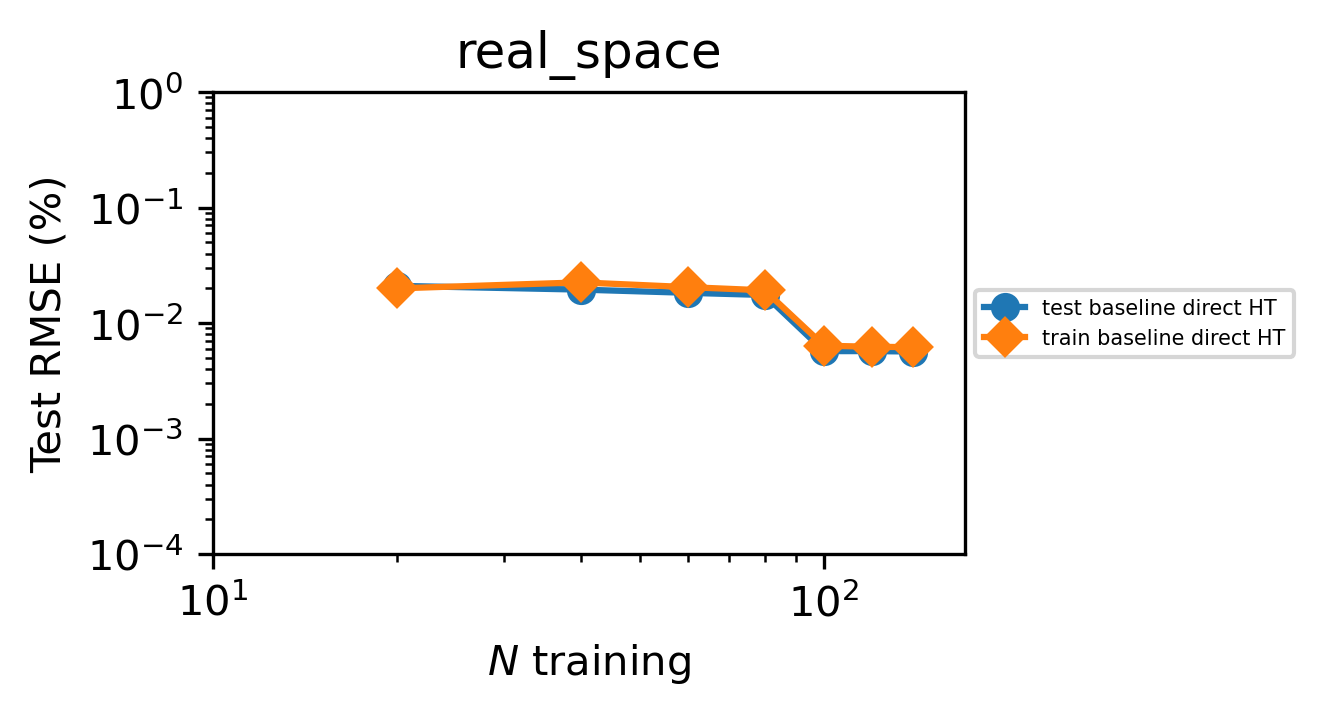

In [16]:
metrics_name = 'RMSE'
target_quantity = 'fock'
is_relative = True


space = 'real_space'

# for strategy in metrics[space]:

strategy = 'b_baseline_direct_HT'
fig, ax = plt.subplots()

if metrics_name == 'RMSE':
    metrics = RMSE
    train_metrics = RMSE_train
elif metrics_name == 'MAE':
    metrics = MAE
    train_metrics = MAE_train

# if metrics[space][strategy] == {}:
    # continue
x = np.array([float(n) for n in metrics[space][strategy]])
if is_relative:
    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
    y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
    unit = '%'
    upper = 1
else:
    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
    y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
    unit = 'meV'
    upper = 10*Hartree*1000
y = y[x.argsort()]
y_train = y_train[x.argsort()]
x = x[x.argsort()]
ax.plot(x, y, '-o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
ax.plot(x, y_train, '-D', label = 'train ' + ' '.join(strategy.split("_")[1:]))


# if metrics_name == 'RMSE':
#     metrics = ridge_RMSE
#     train_metrics = ridge_RMSE_train
# elif metrics_name == 'MAE':
#     metrics = ridge_MAE
#     train_metrics = ridge_MAE_train

# strategy += '_ridge'
# # if metrics[space][strategy] == {}:
# #     continue
# x = np.array([float(n) for n in metrics[space][strategy]])
# if is_relative:
#     y = np.array([metrics[space][strategy][n][target_quantity]/ridge_STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
#     y_train = np.array([train_metrics[space][strategy][n][target_quantity]/ridge_STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
#     unit = '%'
#     lower = 1e-6
#     upper = 1
# else:
#     y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
#     y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
#     unit = 'meV'
#     lower = Hartree*1000
#     upper = 10*Hartree*1000
# y = y[x.argsort()]
# y_train = y_train[x.argsort()]
# x = x[x.argsort()]
# pl1,=ax.plot([x[0], x[-1]], [y[0], y[-1]], 'o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
# pl2,=ax.plot([x[0], x[-1]], [y_train[0], y_train[-1]], 'D', label = 'train ' + ' '.join(strategy.split("_")[1:]))

# ax.plot(x, y, '--', lw = 0.5, color = pl1.get_color())
# ax.plot(x, y_train, '--', lw = 0.5, color = pl2.get_color())

ax.legend(fontsize = 5, bbox_to_anchor = (1,0.5), loc = 'center left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 170)
ax.set_ylim(1e-4, 1)
ax.set_xlabel('$N$ training')
ax.set_title(space)
ax.set_ylabel(f'Test {metrics_name} ({unit})')

Text(0, 0.5, 'Test RMSE (%)')

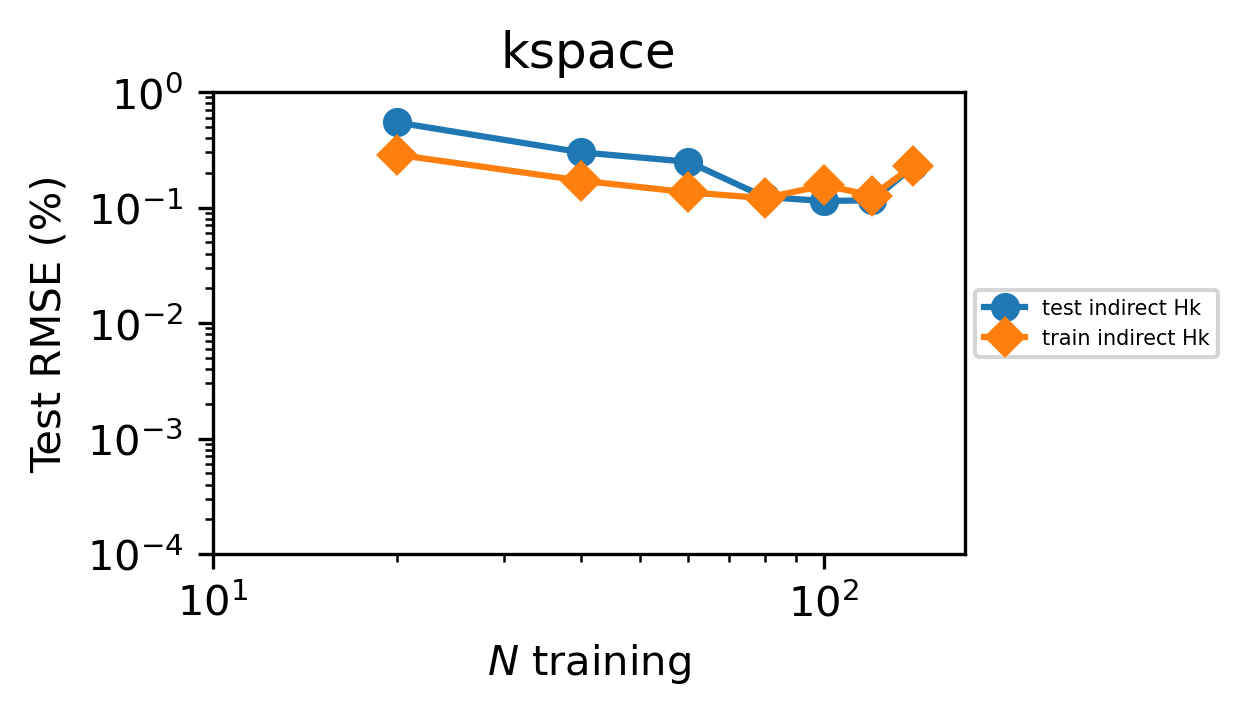

In [17]:
metrics_name = 'RMSE'
target_quantity = 'fock'
is_relative = True


space = 'kspace'

# for strategy in metrics[space]:

strategy = 'd_indirect_Hk'
fig, ax = plt.subplots()

if metrics_name == 'RMSE':
    metrics = RMSE
    train_metrics = RMSE_train
elif metrics_name == 'MAE':
    metrics = MAE
    train_metrics = MAE_train

# if metrics[space][strategy] == {}:
    # continue
x = np.array([float(n) for n in metrics[space][strategy]])
if is_relative:
    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
    y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
    unit = '%'
    upper = 1
else:
    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
    y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
    unit = 'meV'
    upper = 10*Hartree*1000
y = y[x.argsort()]
y_train = y_train[x.argsort()]
x = x[x.argsort()]
ax.plot(x, y, '-o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
ax.plot(x, y_train, '-D', label = 'train ' + ' '.join(strategy.split("_")[1:]))


# if metrics_name == 'RMSE':
#     metrics = RMSE_ridge_k
#     train_metrics = RMSE_ridge_train_k
# elif metrics_name == 'MAE':
#     metrics = ridge_MAE
#     train_metrics = ridge_MAE_train

# strategy += '_ridge'
# # if metrics[space][strategy] == {}:
# #     continue
# metrics = RMSE_ridge_k
# train_metrics = RMSE_ridge_train_k

# x = np.array([float(n) for n in metrics[space][strategy]])
# if is_relative:
#     y = np.array([metrics[space][strategy][n][target_quantity]/STD_ridge_k[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
#     y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train_ridge_k[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*100
#     unit = '%'
#     lower = 1e-6
#     upper = 1
# else:
#     y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
#     y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
#     unit = 'meV'
#     lower = Hartree*1000
#     upper = 10*Hartree*1000
# y = y[x.argsort()]
# y_train = y_train[x.argsort()]
# x = x[x.argsort()]
# pl1,=ax.plot([x[0], x[-1]], [y[0], y[-1]], 'o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
# pl2,=ax.plot([x[0], x[-1]], [y_train[0], y_train[-1]], 'D', label = 'train ' + ' '.join(strategy.split("_")[1:]))

# ax.plot(x, y, '--', lw = 0.5, color = pl1.get_color())
# ax.plot(x, y_train, '--', lw = 0.5, color = pl2.get_color())

ax.legend(fontsize = 5, bbox_to_anchor = (1,0.5), loc = 'center left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 170)
# ax.set_ylim(lower, upper)
ax.set_ylim(1e-4, 1)
ax.set_xlabel('$N$ training')
ax.set_title(space)
ax.set_ylabel(f'Test {metrics_name} ({unit})')

Text(0, 0.5, '$L^2$ loss')

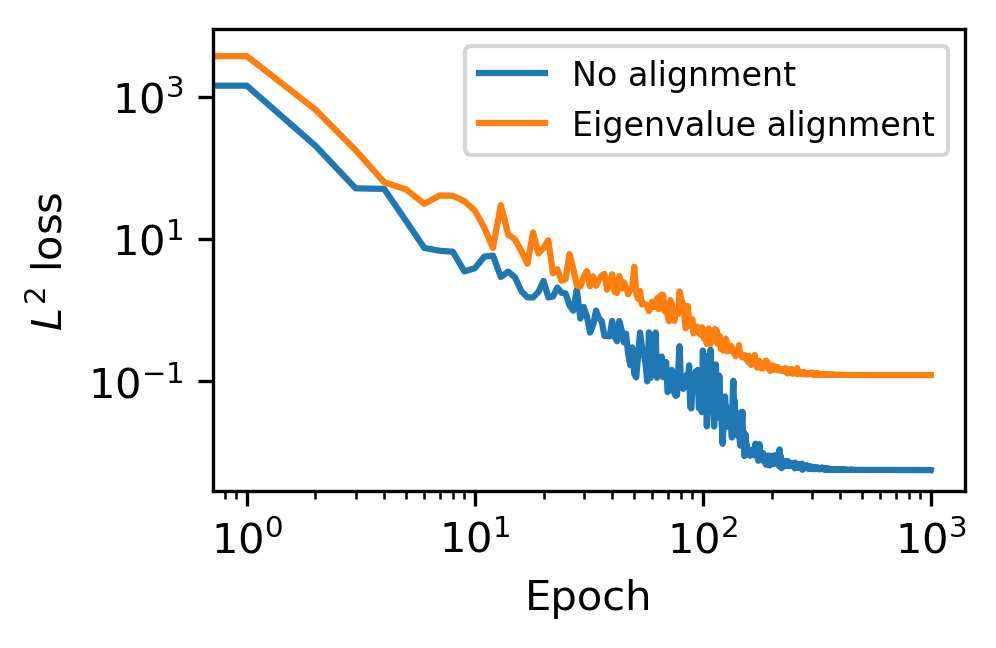

In [26]:
l1 = np.loadtxt('/scratch/pegolo/seed_73/losses/loss_20_nobase.dat')
l2 = np.loadtxt('/scratch/pegolo/seed_73/losses/loss_20_traceless_nobase.dat')

plt.plot(l1[:,1], label = 'No alignment')
plt.plot(l2[:,1], label = 'Eigenvalue alignment')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 8)
plt.xlabel('Epoch')
plt.ylabel('$L^2$ loss')

In [ ]:
np.save('rmse_ridge_kspace', RMSE['kspace'])
np.save('mae_ridge_kspace', MAE['kspace'])

In [ ]:
STD_train

{'real_space': {'a_direct_HT_ridge': {100: {'fock': 1.4903293920674412},
   120: {'fock': 1.4902995913956032},
   140: {'fock': 1.4892765625542572},
   20: {'fock': 1.4905687302098032},
   40: {'fock': 1.4909341787755712},
   60: {'fock': 1.4907009890127214},
   80: {'fock': 1.4857706090900809}},
  'b_baseline_direct_HT_ridge': {100: {'fock': 1.4903293920674412},
   120: {'fock': 1.4902995913956032},
   140: {'fock': 1.4892765625542572},
   20: {'fock': 1.4905687302098032},
   40: {'fock': 1.4909341787755712},
   60: {'fock': 1.4907009890127214},
   80: {'fock': 1.4857706090900809}}},
 'kspace': {'d_indirect_Hk_ridge': {100: {'fock': 1.4903293920674412},
   120: {'fock': 1.4902995913956032},
   140: {'fock': 1.4892765625542572},
   20: {'fock': 1.4905687302098032},
   40: {'fock': 1.4909341787755712},
   60: {'fock': 1.4907009890127214},
   80: {'fock': 1.4857706090900809}},
  'e_baseline_indirect_Hk_ridge': {100: {'fock': 1.4903293920674412},
   120: {'fock': 1.4902995913956032},
   1

In [ ]:
RMSE_train

{'real_space': {'a_direct_HT_ridge': {100: {'fock': 0.00010675299935529018},
   120: {'fock': 0.000693541372121526},
   140: {'fock': 0.0015532821356309013},
   20: {'fock': 0.00013106938364328897},
   40: {'fock': 0.000944257709720899},
   60: {'fock': 0.0021563734045058043},
   80: {'fock': 0.0009850769514329568}},
  'b_baseline_direct_HT_ridge': {100: {'fock': 8.57670022734387e-06},
   120: {'fock': 7.59299202995169e-06},
   140: {'fock': 1.3602255524749378e-05},
   20: {'fock': 3.876184313027599e-06},
   40: {'fock': 2.279254943574785e-05},
   60: {'fock': 2.7556514386013003e-05},
   80: {'fock': 1.645140248756439e-05}}},
 'kspace': {'d_indirect_Hk_ridge': {100: {'fock': tensor(0.0116)},
   120: {'fock': tensor(0.0083)},
   140: {'fock': tensor(0.3946)},
   20: {'fock': tensor(0.0005)},
   40: {'fock': tensor(0.0027)},
   60: {'fock': tensor(0.0205)},
   80: {'fock': tensor(0.0227)}},
  'e_baseline_indirect_Hk_ridge': {100: {'fock': tensor(530489.2361)},
   120: {'fock': tensor(530

In [ ]:
np.save('rmse_ridge_train_kspace', RMSE_train['kspace'])

In [ ]:
STD

{'real_space': {'a_direct_HT_ridge': {100: {'eigvals': 3.9233951200143915,
    'fock': 1.4885022487242474},
   120: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   140: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   20: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   40: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   60: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   80: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474}},
  'b_baseline_direct_HT_ridge': {100: {'eigvals': 3.9233951200143915,
    'fock': 1.4885022487242474},
   120: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   140: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   20: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   40: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   60: {'eigvals': 3.9233951200143915, 'fock': 1.4885022487242474},
   80: {'eigvals': 3.923395120014391

In [ ]:
RMSE['kspace']['d_indirect_Hk_ridge']

{100: {'eigvals': 0.4968138066049664, 'fock': tensor(0.0182)},
 120: {'eigvals': 0.49685966611193483, 'fock': tensor(0.0134)},
 140: {'eigvals': 0.4962308243680505, 'fock': tensor(0.6250)},
 20: {'eigvals': 0.49667262517140326, 'fock': tensor(0.0074)},
 40: {'eigvals': 0.4967198842084674, 'fock': tensor(0.0049)},
 60: {'eigvals': 0.4970177817506336, 'fock': tensor(0.0321)},
 80: {'eigvals': 0.4968058882033346, 'fock': tensor(0.0387)}}

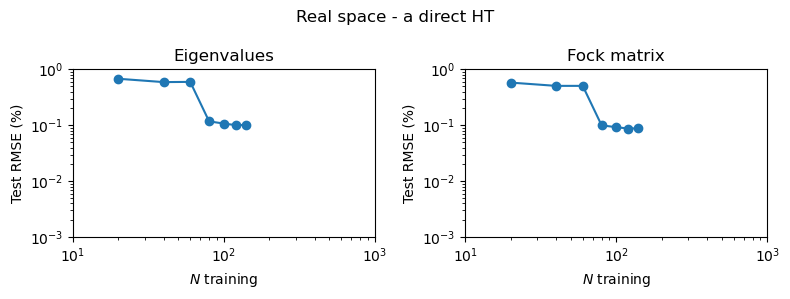

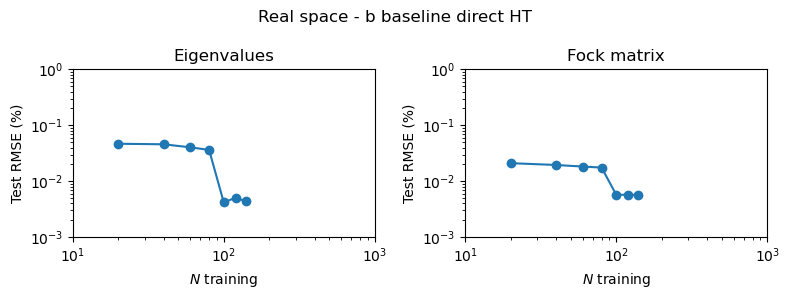

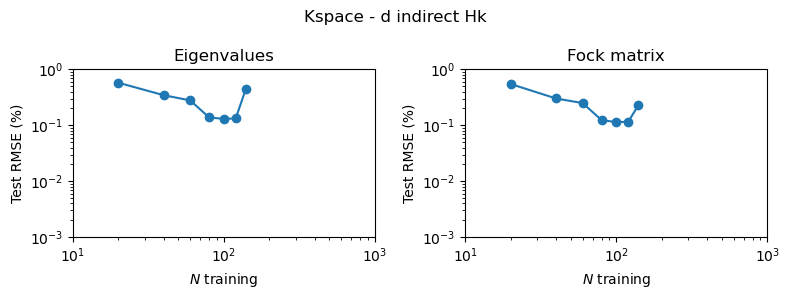

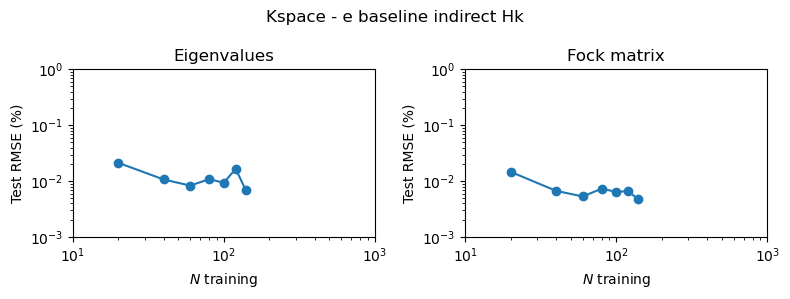

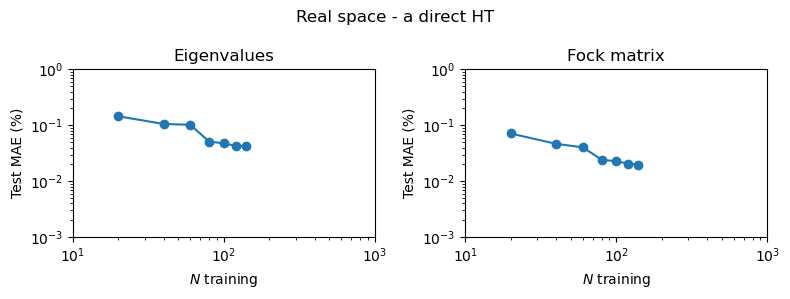

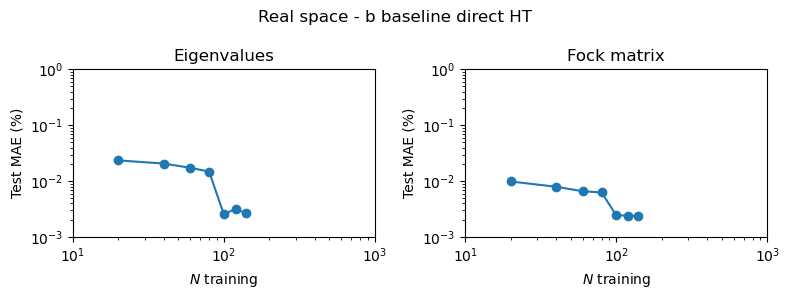

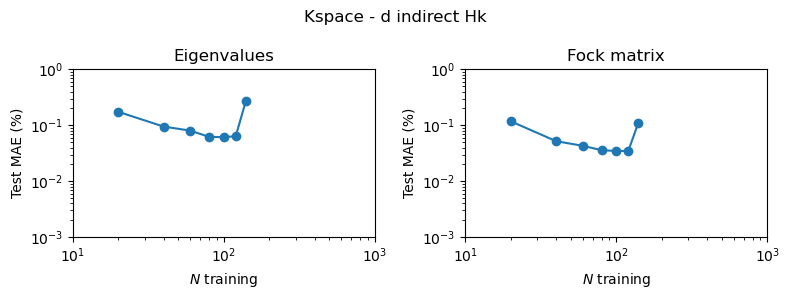

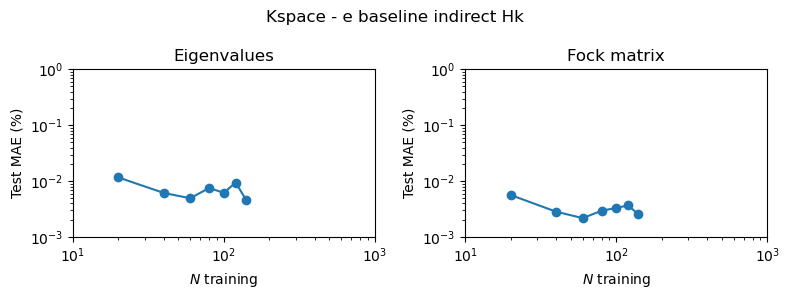

In [ ]:
from ase.units import Hartree
is_relative = True
for metrics, metrics_name in zip([RMSE, MAE], ['RMSE', 'MAE']):
    
    for space in metrics:
        
        for strategy in metrics[space]:
    
            if metrics[space][strategy] == {}:
                continue
            
            fig, axes = plt.subplots(ncols = 2, figsize = (8, 3))
            
            for ax, target_quantity, target_name in zip(axes, ['eigvals', 'fock'], ['Eigenvalues', 'Fock matrix']):
                x = np.array([float(n) for n in metrics[space][strategy]])
                if is_relative:
                    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
                    unit = '%'
                    lower = 1e-3
                    upper = 1
                else:
                    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
                    unit = 'meV'
                    lower = 0.5
                    upper = 1000
                y = y[x.argsort()]
                x = x[x.argsort()]
                ax.plot(x, y, '-o')
                
                ax.set_xlabel('$N$ training')
                ax.set_ylabel(f'Test {metrics_name} ({unit})')
                
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim(10, 1000)
                ax.set_ylim(lower, upper)
                
                ax.set_title(target_name)
    
            title = ' '.join(space.capitalize().split('_')) + ' - ' + ' '.join(strategy.split("_")[:])
            fig.suptitle(title)
            fig.tight_layout()

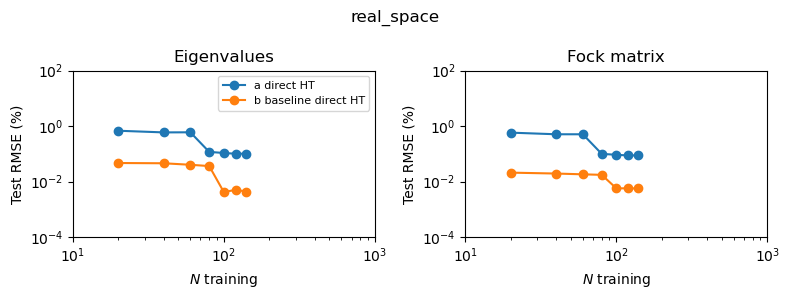

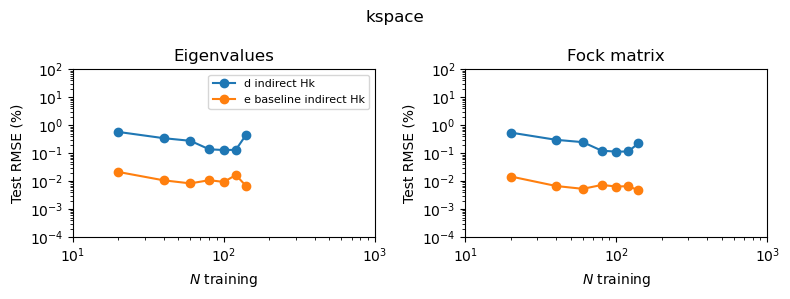

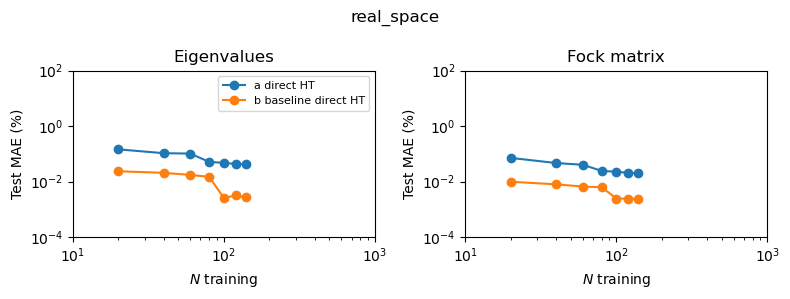

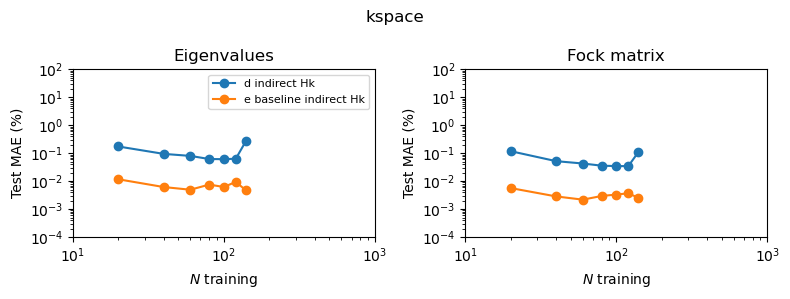

In [ ]:
from ase.units import Hartree
is_relative = True
for metrics, metrics_name in zip([RMSE, MAE], ['RMSE', 'MAE']):
    
    for space in metrics:

        fig, axes = plt.subplots(ncols = 2, figsize = (8, 3))
      
        for strategy in metrics[space]:
    
            if metrics[space][strategy] == {}:
                continue
            
            
            for i, (ax, target_quantity, target_name) in enumerate(zip(axes, ['eigvals', 'fock'], ['Eigenvalues', 'Fock matrix'])):
                x = np.array([float(n) for n in metrics[space][strategy]])
                if is_relative:
                    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
                    unit = '%'
                    upper = 100
                else:
                    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
                    unit = 'meV'
                    upper = 10*Hartree*1000
                y = y[x.argsort()]
                x = x[x.argsort()]
                ax.plot(x, y, '-o', label = ' '.join(strategy.split("_")))
                
                ax.set_xlabel('$N$ training')
                ax.set_ylabel(f'Test {metrics_name} ({unit})')
                
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim(10, 1000)
                ax.set_ylim(1e-4, upper)
                
                ax.set_title(target_name)

                if i == 0: ax.legend(fontsize = 8)
            # title = ' '.join(space.capitalize().split('_')) + ' - ' + ' '.join(strategy.split("_")[:])
        fig.suptitle(space)
        fig.tight_layout()

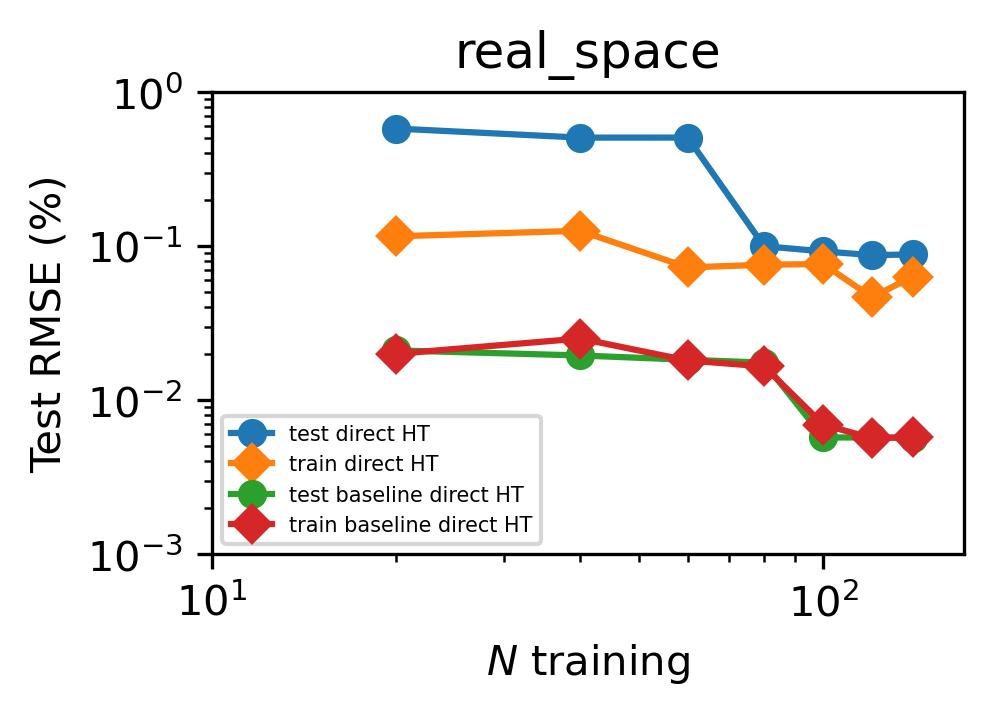

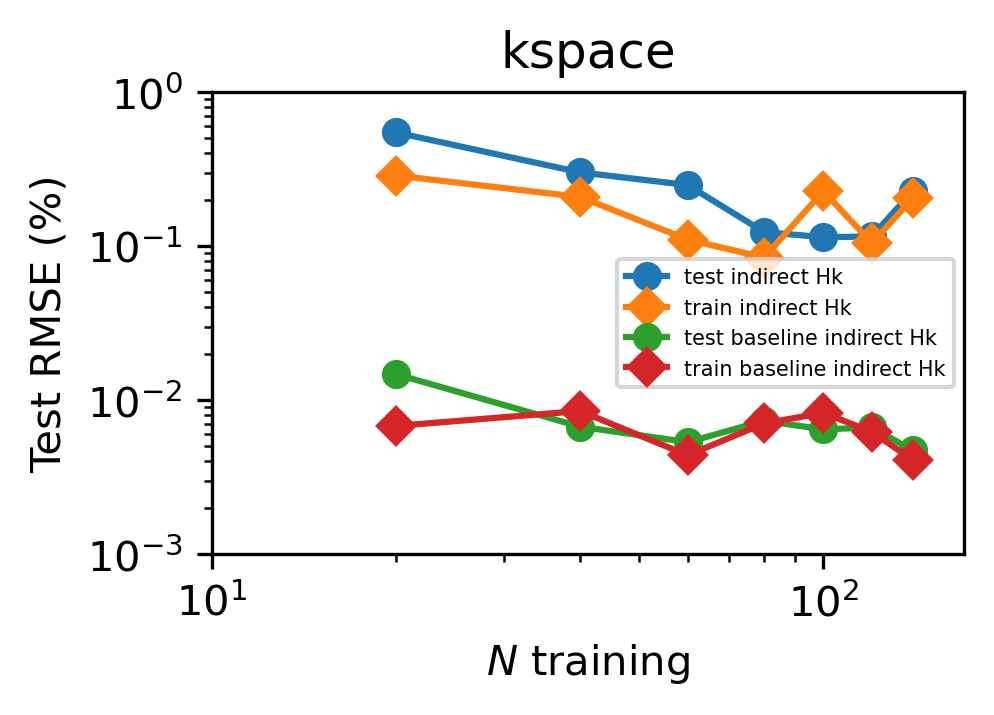

In [ ]:
metrics_name = 'RMSE'
target_quantity = 'fock'

if metrics_name == 'RMSE':
    metrics = RMSE
    train_metrics = RMSE_train
elif metrics_name == 'MAE':
    metrics = MAE
    train_metrics = MAE_train

for space in metrics:
    
    fig, ax = plt.subplots()
    
    
    for strategy in metrics[space]:
        if metrics[space][strategy] == {}:
            continue
        x = np.array([float(n) for n in metrics[space][strategy]])
        if is_relative:
            y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
            y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
            unit = '%'
            upper = 1
        else:
            y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
            y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
            unit = 'meV'
            upper = 10*Hartree*1000
        y = y[x.argsort()]
        y_train = y_train[x.argsort()]
        x = x[x.argsort()]
        ax.plot(x, y, '-o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
        ax.plot(x, y_train, '-D', label = 'train ' + ' '.join(strategy.split("_")[1:]))
    
    ax.legend(fontsize = 5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 170)
    ax.set_ylim(lower, upper)
    ax.set_xlabel('$N$ training')
    ax.set_title(space)
    ax.set_ylabel(f'Test {metrics_name} ({unit})')

In [ ]:
ed = np.load(f'/scratch/pegolo/seed_73/test_results/b_baseline_direct_HT_eigenvalues.npy', allow_pickle = True).item()

In [ ]:
ed = np.load(f'/scratch/pegolo/seed_73/test_results/a_direct_HT_eigenvalues.npy', allow_pickle = True).item()

In [ ]:
from ase.units import Hartree

[-9.72835566 -9.72650568] [-9.72818306 -9.72633   ]
[-9.74323471 -9.74001405] [-9.74335611 -9.74013486]
[-9.74061114 -9.73757129] [-9.74060215 -9.73756115]
[-9.7260328 -9.7245144] [-9.72591949 -9.72439795]
[-9.7277601  -9.72587808] [-9.72785308 -9.72596711]
[-9.72773559 -9.72593979] [-9.72798448 -9.72619143]
[-9.73705796 -9.7342877 ] [-9.73698062 -9.73420769]
[-9.74245713 -9.73929344] [-9.742535   -9.73936736]
[-9.74890439 -9.74538996] [-9.74897613 -9.74545582]
[-9.73183688 -9.729623  ] [-9.73185527 -9.72964112]
[-9.74811025 -9.74462723] [-9.74818196 -9.74469811]
[-9.7378843  -9.73503804] [-9.73789163 -9.73503951]
[-9.74971942 -9.74617002] [-9.74972596 -9.74617179]
[-9.73847475 -9.73571292] [-9.73832791 -9.735565  ]
[-9.74687122 -9.7435241 ] [-9.74663676 -9.74328509]
[-9.73985018 -9.73688542] [-9.73974168 -9.73677594]
[-9.73551856 -9.73288212] [-9.73544616 -9.7328076 ]
[-9.75199469 -9.74834511] [-9.75163791 -9.74798534]
[-9.73752064 -9.73470873] [-9.73747994 -9.73466535]
[-9.73987069 -

(-267.0, -262.0)

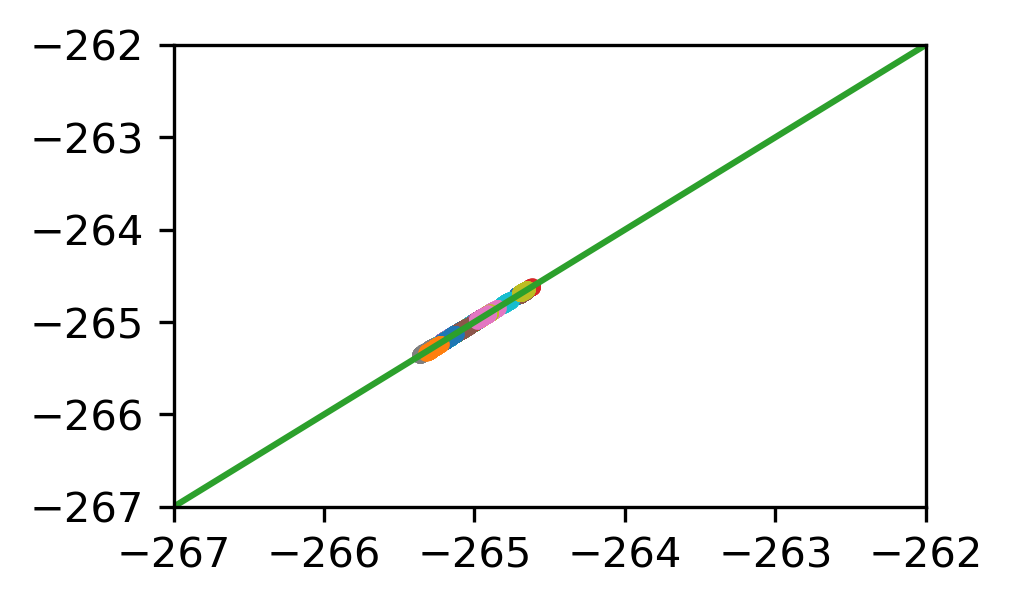

In [ ]:
for ifr in range(ed['target'].shape[0]):
    x = ed['target'][ifr].flatten()
    y = ed['prediction'][ifr].flatten()
    print(x[0:2], y[0:2])
    plt.plot(x[x>-500]*Hartree, y[x>-500]*Hartree, '.', label = ifr)
# plt.legend()
plt.plot([-10*Hartree, 2*Hartree], [-10*Hartree,2*Hartree])
plt.xlim([-267,-262])
plt.ylim([-267,-262])

In [ ]:
x, y = np.load('/scratch/pegolo/seed_73/test_results/a_direct_HT_fock.npy').T

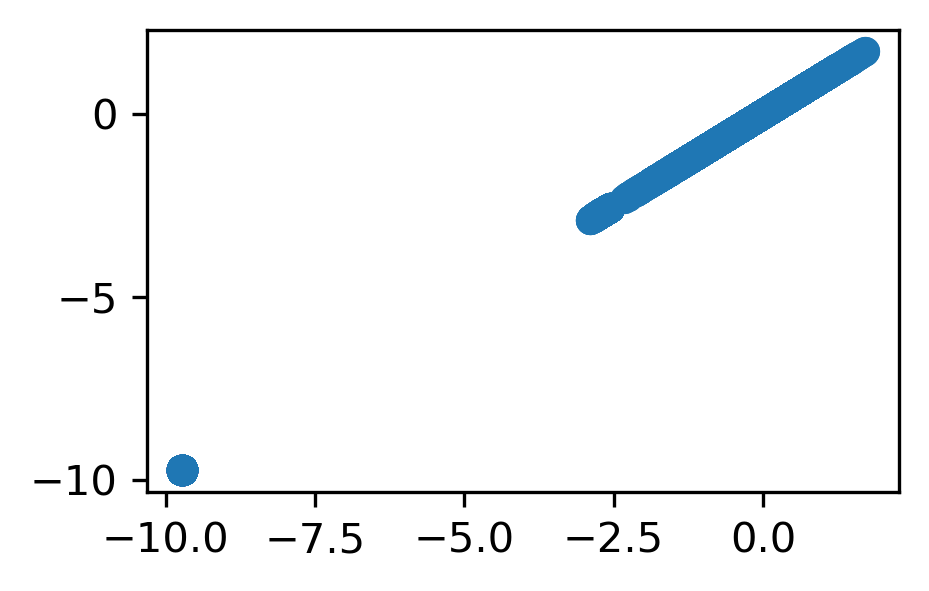

In [ ]:
# plt.plot(x*Hartree, y*Hartree, 'o')
# plt.plot([-275, 55], [-275, 55])

plt.plot(x, y, 'o')
# plt.plot([-275, 55], [-275, 55])

In [ ]:
from mlelec.utils.plot_utils import plot_block_errors

[6.87412393e-05 8.30776005e+00 6.71552965e+00 7.55353523e-01
 7.78988650e+01 2.13482414e+01 4.86062299e-03 1.04085114e+01
 1.60257502e-01 3.51469664e+00 1.31392547e+00 3.16546574e-04
 4.98979335e+00 1.43837402e-04 6.98281590e+00 3.58865751e-01
 1.33224352e+00 4.95728979e+00] [6.87412340e-05 4.18055448e-02 2.13065428e-02 1.56766816e-02
 1.06350823e+00 2.34852879e-01 4.86062299e-03 7.34055768e-02
 9.83914518e-03 1.77252991e-02 1.33025219e-02 3.34130742e-04
 2.13948447e-02 1.43837402e-04 2.74957797e-02 1.84093008e-03
 8.32937064e-03 1.80359072e-02]


(1e-18, 1000.0)

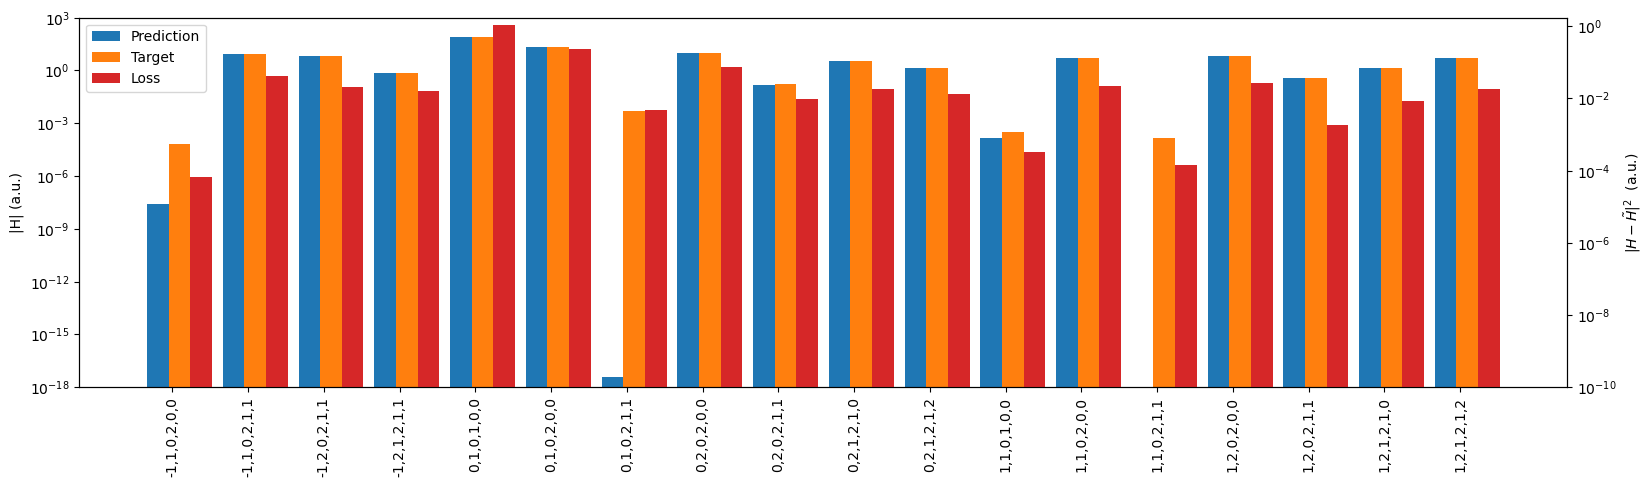

In [ ]:
check = torch.load(f'/scratch/pegolo/benchmarks/real_space/a_direct_HT/train_0_140/model_950.ckpt')
    
model.load_state_dict(check['model_state_dict'])

pred_HT_blocks = model.predict(test_features, test_HT_blocks)

fig, ax1, ax2 = plot_block_errors(test_HT_blocks, pred_HT_blocks, plot_loss=True)
ax1.set_ylim(1e-18)

In [ ]:
np.array([rfock0[i][0,0,0][0,0] - rfock[i][0,0,0][0,0] for i in range(32)])

array([0.14373749, 0.14044134, 0.13922365, 0.14170677, 0.15008971,
       0.13931898, 0.13636292, 0.14289178, 0.13932919, 0.13379281,
       0.1450813 , 0.13417465, 0.15122621, 0.13635444, 0.13932292,
       0.13616751, 0.13932214, 0.14339478, 0.14123826, 0.14415596,
       0.12888625, 0.15025246, 0.11673246, 0.14062321, 0.143124  ,
       0.12104207, 0.14919764, 0.13397831, 0.13386869, 0.12834788,
       0.14624804, 0.15177004])

(1e-18, 1000.0)

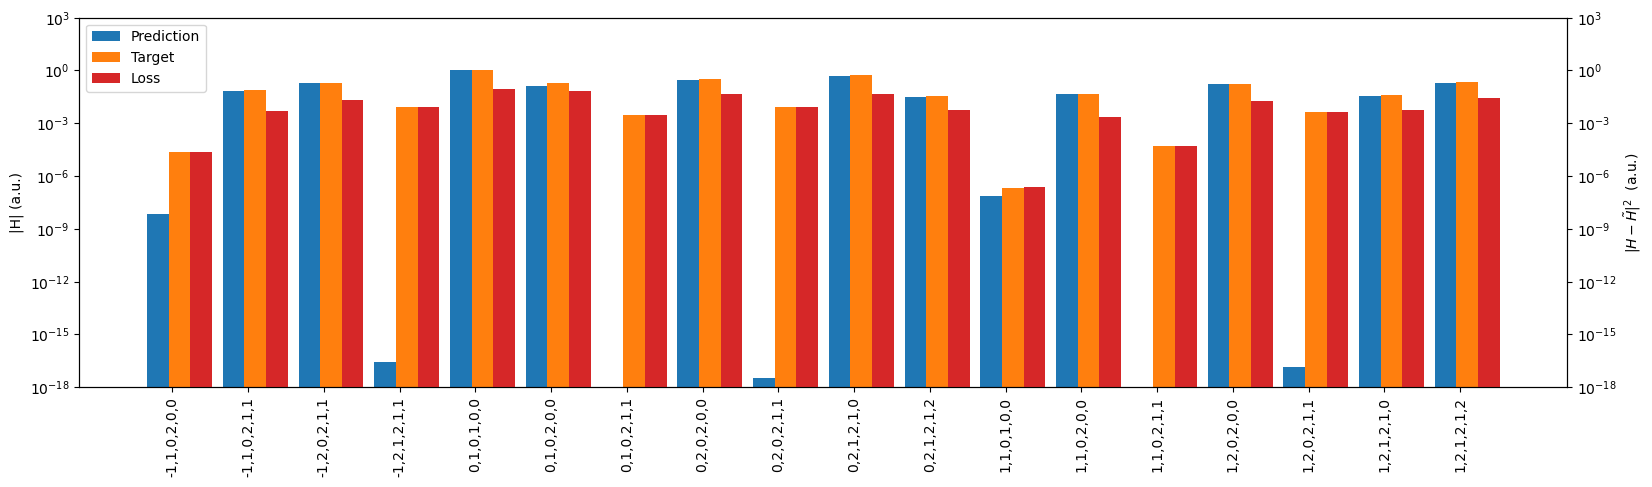

In [ ]:
check = torch.load(f'/scratch/pegolo/benchmarks/real_space/b_baseline_direct_HT/train_0_80/model_50.ckpt')
    
model.load_state_dict(check['model_state_dict'])

pred_HT_blocks = model.predict(test_features, test_HT_blocks)

# fig, ax1, ax2 = plot_block_errors(test_HT_blocks, pred_HT_blocks, plot_loss=True)
# fig, ax1, ax2 = plot_block_errors(test_HT_blocks, baseline_blocks, plot_loss=True)
# fig, ax1, ax2 = plot_block_errors(mts.add(baseline_blocks, pred_HT_blocks), test_HT_blocks, plot_loss=True)
fig, ax1, ax2 = plot_block_errors(mts.subtract(test_HT_blocks, baseline_blocks), pred_HT_blocks, plot_loss=True)

ax1.set_ylim(1e-18, 1e3)
ax2.set_ylim(1e-18, 1e3)

In [ ]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
feat = map_targetkeys_to_featkeys(test_features, test_HT_blocks.keys[6])

In [ ]:
feat.values

tensor([[[-1.0701e-03, -4.2330e-03, -1.5601e-02,  ..., -1.3855e-03,
           3.5782e-04,  7.8105e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-6.9213e-04, -2.3765e-03, -9.0619e-03,  ...,  2.4337e-03,
          -2.4401e-03, -2.3797e-03]],

        [[ 1.0701e-03,  4.2330e-03,  1.5601e-02,  ...,  1.3855e-03,
          -3.5782e-04, -7.8105e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.9213e-04,  2.3765e-03,  9.0619e-03,  ..., -2.4337e-03,
           2.4401e-03,  2.3797e-03]],

        [[-1.3774e-03, -9.9573e-03, -1.8866e-02,  ...,  2.9378e-04,
           9.6024e-05, -4.4549e-04],
         [-8.9616e-04,  5.7952e-04, -1.2487e-02,  ..., -1.6296e-03,
          -1.3680e-03, -8.1218e-04],
         [-2.7006e-03, -1.6087e-02, -3.5818e-02,  ...,  6.5219e-05,
          -1.9880e-04, -6.0619e-04]],

        ...,

        [[ 3.1810e-03,  1.5780e-02,

(1e-18, 1000.0)

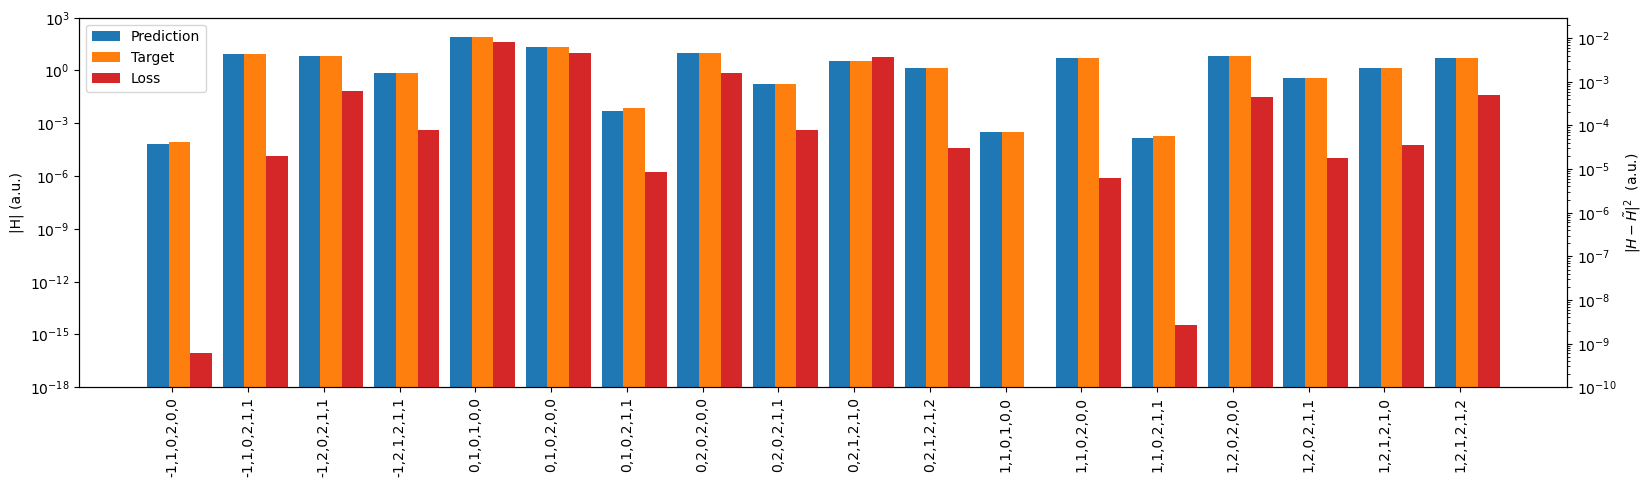

In [ ]:
check = torch.load(f'/scratch/pegolo/benchmarks/real_space/c_traceless_learning_direct_HT/train_0_80/model_50.ckpt')
    
model.load_state_dict(check['model_state_dict'])

pred_HT_blocks = model.predict(test_features, test_HT_blocks)

fig, ax1, ax2 = plot_block_errors(mts.add(baseline_blocks, pred_HT_blocks), test_HT_blocks, plot_loss=True)
ax1.set_ylim(1e-18)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

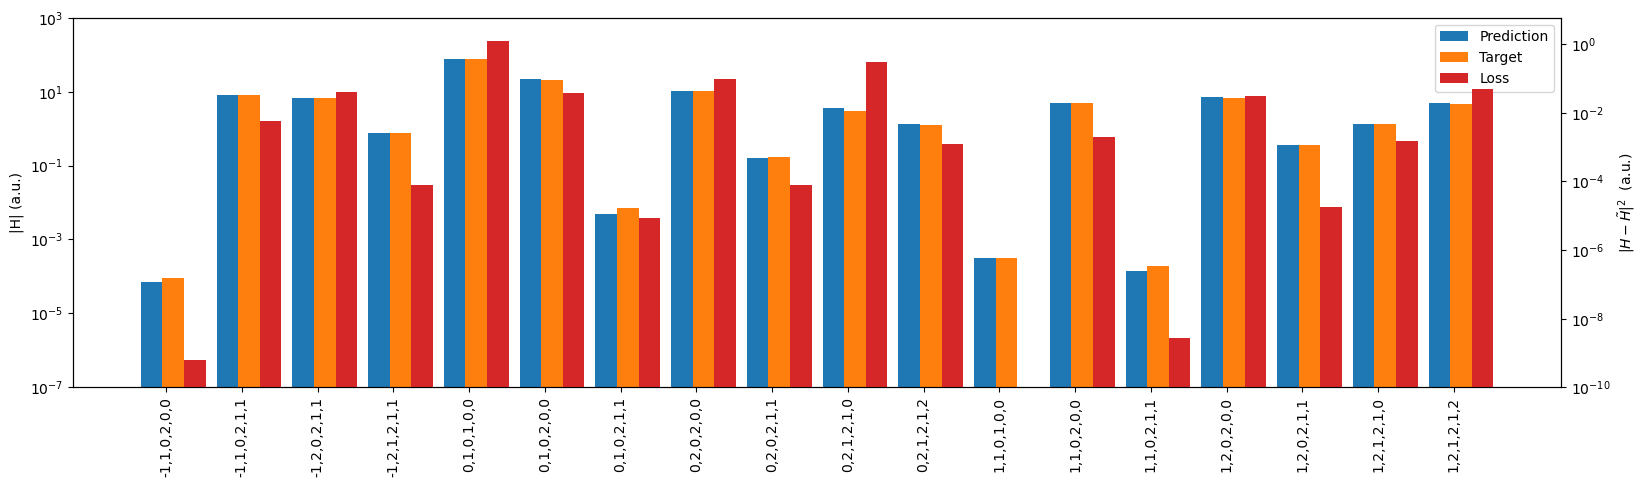

In [ ]:
plot_block_errors(baseline_blocks, test_HT_blocks, plot_loss=True)

In [ ]:
from mlelec.metrics import L2_loss

In [ ]:
L2_loss()

# RIDGE

In [10]:
# Initialize model
model = LinearModelPeriodic(twocfeat = test_features, 
                             target_blocks = test_HT_blocks,
                             frames = dataset.structures, orbitals = dataset.basis, 
                             device = device,
                             bias = True,
                             nhidden = nhidden, 
                             nlayers = nlayers,
                             activation = 'SiLU',
                             apply_norm = True)
model = model.double()

In [11]:
# Compute metrics

RMSE = {}
MAE = {}
STD = {}

RMSE_train = {}
MAE_train = {}
STD_train = {}


In [12]:
len(train_datasets[120])

120

In [13]:

for space in ['real_space']:#, 'kspace']:

    ridge_RMSE[space] = {}
    ridge_MAE[space] = {}
    ridge_STD[space] = {}

    ridge_RMSE_train[space] = {}
    ridge_MAE_train[space] = {}
    ridge_STD_train[space] = {}

    folders = glob(f'{root}/benchmarks/{space}/*_ridge')
    
    for folder in folders:
        
        fname = folder.split('/')[-1]

        ridge_RMSE[space][fname] = {}
        ridge_MAE[space][fname] = {}
        ridge_STD[space][fname] = {}

        ridge_RMSE_train[space][fname] = {}
        ridge_MAE_train[space][fname] = {}
        ridge_STD_train[space][fname] = {}

        if 'baseline' in fname.split('_') or 'traceless' in fname.split('_'):
            is_baseline = True
        else:
            is_baseline = False

        if 'orthogonalized' in fname.split('_'):
            is_ortho = True
        else:
            is_ortho = False

        print(f'Analyzing {fname}. is_baseline = {is_baseline}; is_ortho = {is_ortho}', flush = True)

        if is_ortho:
            overlap_mat = None
        else:
            overlap_mat = overlap_matrices

        if is_baseline:
            baseline = baseline_target
        else:
            baseline = None
        
        # Load trained models
        # checkpoint = {}
        train_folders = glob(f'{folder}/train_*')
        for train_folder in train_folders:
            parent = '/'.join(train_folder.split('/')[:-1])
            nstruc = int(train_folder.split('/')[-1].split('_')[2])
            print(f'    {nstruc} {train_folder}')

            # ckpts = glob(f'{train_folder}/*ckpt')
            # if len(ckpts):
            if True:
                
                ridge_RMSE[space][fname][nstruc] = {}
                ridge_MAE[space][fname][nstruc] = {}
                ridge_STD[space][fname][nstruc] = {}

                ridge_RMSE_train[space][fname][nstruc] = {}
                ridge_MAE_train[space][fname][nstruc] = {}
                ridge_STD_train[space][fname][nstruc] = {}
                
                # last_model = max([int(ckpt.split('/')[-1].split('.')[0].split('_')[1]) for ckpt in ckpts])
    
                print(f'    {train_folder}: loading ridge model', flush = True)
                # checkpoint[nstruc] = torch.load(f'{train_folder}/model_{last_model}.ckpt')
                # model.load_state_dict(checkpoint[nstruc]['model_state_dict'])
                ridges = np.load(f'{parent}/ridges_bias_{nstruc}.npy', allow_pickle=True)

                # Train metrics

                if is_ortho:
                    train_overlap_mat = train_overlap_matrices[0:nstruc]
                else:
                    train_overlap_mat = None

                if is_baseline:
                    train_baseline = train_baseline_target[0:nstruc]
                else:
                    train_baseline = None
                
                pred_HT_blocks = model.predict_ridge_analytical(ridges, train_features[nstruc], train_targets[nstruc])
                pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, train_datasets[nstruc], baseline = train_baseline, overlap_matrices = train_overlap_mat)

                # ridge_RMSE_train[space][fname][nstruc]['eigvals'] = rmse_vector(target_eigvals, pred_eigvals)
                ridge_RMSE_train[space][fname][nstruc]['fock'] = rmse_vector(torch.stack(train_target_matrices[:nstruc]).numpy(), pred_Hk.numpy())
                # ridge_MAE_train[space][fname][nstruc]['eigvals'] = mae_vector(target_eigvals, pred_eigvals)
                ridge_MAE_train[space][fname][nstruc]['fock'] = mae_vector(torch.stack(train_target_matrices[:nstruc]).numpy(), pred_Hk.numpy())
                # ridge_STD_train[space][fname][nstruc]['eigvals'] = target_eigvals.flatten().std()
                ridge_STD_train[space][fname][nstruc]['fock'] = torch.stack(train_target_matrices[:nstruc]).numpy().std()
               
                # Test metrics
                pred_HT_blocks = model.predict_ridge_analytical(ridges, test_features, test_HT_blocks) #model.predict(test_features, test_HT_blocks)
                pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, dataset, baseline = baseline, overlap_matrices = overlap_mat)
    
                eig_dict = {'target': target_eigvals, 'prediction': pred_eigvals}
                # np.save(f'{results_dir}/{fname}_eigenvalues.npy', eig_dict)
                # np.save(f'{results_dir}/{fname}_fock.npy', np.array([np.concatenate([target_matrices.numpy().flatten().real,target_matrices.numpy().flatten().imag]),
                #                                                      np.concatenate([pred_Hk.numpy().flatten().real,pred_Hk.numpy().flatten().imag])]).T)

                ridge_RMSE[space][fname][nstruc]['eigvals'] = rmse_vector(target_eigvals, pred_eigvals)
                ridge_RMSE[space][fname][nstruc]['fock'] = rmse_vector(target_matrices.numpy(), pred_Hk.numpy())
                ridge_MAE[space][fname][nstruc]['eigvals'] = mae_vector(target_eigvals, pred_eigvals)
                ridge_MAE[space][fname][nstruc]['fock'] = mae_vector(target_matrices.numpy(), pred_Hk.numpy())
                ridge_STD[space][fname][nstruc]['eigvals'] = target_eigvals.flatten().std()
                ridge_STD[space][fname][nstruc]['fock'] = target_matrices.numpy().std()
                
                print(f'    ridge_RMSE {fname} {nstruc} eigvals {ridge_RMSE[space][fname][nstruc]["eigvals"]}', flush = True)
                print(f'    ridge_RMSE {fname} {nstruc} fock {ridge_RMSE[space][fname][nstruc]["fock"]}', flush = True)
    
                print(f'    ridge_MAE {fname} {nstruc} eigvals {ridge_MAE[space][fname][nstruc]["eigvals"]}', flush = True)
                print(f'    ridge_MAE {fname} {nstruc} fock {ridge_MAE[space][fname][nstruc]["fock"]}', flush = True)
            else:
                print('    Empty folder!')

Analyzing a_direct_HT_ridge. is_baseline = False; is_ortho = False
    100 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_100
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_100: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 100 eigvals 0.0008432282610490176
    RMSE a_direct_HT_ridge 100 fock 0.00017400586111617728
    MAE a_direct_HT_ridge 100 eigvals 0.00032644179951473346
    MAE a_direct_HT_ridge 100 fock 5.7779264275142694e-05
    120 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_120
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_120: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 120 eigvals 0.0018852069171288181
    RMSE a_direct_HT_ridge 120 fock 0.0006947481902898661
    MAE a_direct_HT_ridge 120 eigvals 0.0012312161034329866
    MAE a_direct_HT_ridge 120 fock 0.00033346825723519865
    140 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_140
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_140: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 140 eigvals 0.0018696704489899957
    RMSE a_direct_HT_ridge 140 fock 0.0015423655685162423
    MAE a_direct_HT_ridge 140 eigvals 0.0014637554756244283
    MAE a_direct_HT_ridge 140 fock 0.0007144924720615853
    20 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_20
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_20: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 20 eigvals 0.003657459099226578
    RMSE a_direct_HT_ridge 20 fock 0.000530498593631563
    MAE a_direct_HT_ridge 20 eigvals 0.0014124319592220057
    MAE a_direct_HT_ridge 20 fock 0.00016054596287531735
    40 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_40
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_40: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 40 eigvals 0.0015272369646811975
    RMSE a_direct_HT_ridge 40 fock 0.0009437758670611318
    MAE a_direct_HT_ridge 40 eigvals 0.0009117079205561259
    MAE a_direct_HT_ridge 40 fock 0.0003418480166653828
    60 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_60
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_60: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 60 eigvals 0.0034559661363877986
    RMSE a_direct_HT_ridge 60 fock 0.0021498634336384855
    MAE a_direct_HT_ridge 60 eigvals 0.00199291733284113
    MAE a_direct_HT_ridge 60 fock 0.0007037270764160125
    80 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_80
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/a_direct_HT_ridge/train_0_80: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE a_direct_HT_ridge 80 eigvals 0.002605578823571823
    RMSE a_direct_HT_ridge 80 fock 0.0010282480887572607
    MAE a_direct_HT_ridge 80 eigvals 0.0015766058154215285
    MAE a_direct_HT_ridge 80 fock 0.0005256606910056193
Analyzing b_baseline_direct_HT_ridge. is_baseline = True; is_ortho = False
    100 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_100
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_100: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 100 eigvals 0.00021931508524293116
    RMSE b_baseline_direct_HT_ridge 100 fock 3.798658526221331e-05
    MAE b_baseline_direct_HT_ridge 100 eigvals 7.662558118192381e-05
    MAE b_baseline_direct_HT_ridge 100 fock 1.044446877941972e-05
    120 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_120
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_120: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 120 eigvals 0.00023613865802409373
    RMSE b_baseline_direct_HT_ridge 120 fock 4.473223004096014e-05
    MAE b_baseline_direct_HT_ridge 120 eigvals 7.646286788174421e-05
    MAE b_baseline_direct_HT_ridge 120 fock 1.0277575625621353e-05
    140 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_140
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_140: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 140 eigvals 0.00010572231527587641
    RMSE b_baseline_direct_HT_ridge 140 fock 2.4697169153914553e-05
    MAE b_baseline_direct_HT_ridge 140 eigvals 4.9351755343450346e-05
    MAE b_baseline_direct_HT_ridge 140 fock 1.0981941012944613e-05
    20 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_20
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_20: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 20 eigvals 0.0003904371442205927
    RMSE b_baseline_direct_HT_ridge 20 fock 7.25940931523127e-05
    MAE b_baseline_direct_HT_ridge 20 eigvals 0.00016454477886624694
    MAE b_baseline_direct_HT_ridge 20 fock 2.3373323685195053e-05
    40 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_40
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_40: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 40 eigvals 0.0004153236576445737
    RMSE b_baseline_direct_HT_ridge 40 fock 9.28372640834797e-05
    MAE b_baseline_direct_HT_ridge 40 eigvals 0.00015206446871633505
    MAE b_baseline_direct_HT_ridge 40 fock 2.5661693553108513e-05
    60 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_60
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_60: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 60 eigvals 0.0009957667206628752
    RMSE b_baseline_direct_HT_ridge 60 fock 0.0001737862519416151
    MAE b_baseline_direct_HT_ridge 60 eigvals 0.00030013959011181276
    MAE b_baseline_direct_HT_ridge 60 fock 3.508902025070766e-05
    80 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_80
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/real_space/b_baseline_direct_HT_ridge/train_0_80: loading ridge model


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/mlelec/models/linear.py:782: UserWarning: Overwiting ridges with fitted ridges
  warnings.warn('Overwiting ridges with fitted ridges')


    RMSE b_baseline_direct_HT_ridge 80 eigvals 0.00032423873659089035
    RMSE b_baseline_direct_HT_ridge 80 fock 5.525232758669872e-05
    MAE b_baseline_direct_HT_ridge 80 eigvals 0.0001384899676043691
    MAE b_baseline_direct_HT_ridge 80 fock 1.9167648017778382e-05


In [16]:
np.save('rmse_ridge_realspace', RMSE)
np.save('mae_ridge_realspace', MAE)

np.save('rmse_ridge_realspace_train', RMSE_train)
np.save('mae_ridge_realspace_train', MAE_train)

np.save('std_realspace', STD)
np.save('std_realspace_train', STD_train)

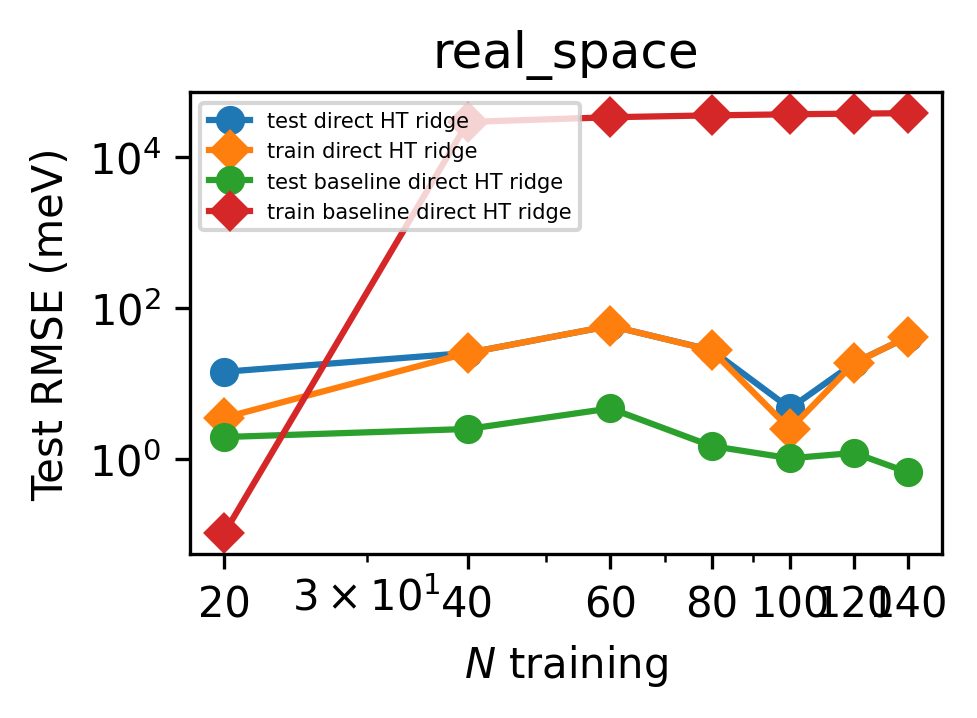

In [34]:
metrics_name = 'RMSE'
target_quantity = 'fock'
is_relative = False
from ase.units import Hartree

if metrics_name == 'RMSE':
    metrics = RMSE
    train_metrics = RMSE_train
elif metrics_name == 'MAE':
    metrics = MAE
    train_metrics = MAE_train

for space in ['real_space']:
    
    fig, ax = plt.subplots()
    
    
    for strategy in  metrics[space]:
        if metrics[space][strategy] == {}:
            continue
        x = np.array([float(n) for n in metrics[space][strategy]])
        if is_relative:
            y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
            y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
            unit = '%'
            lower = 1e-6
            upper = 1
        else:
            y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
            y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
            unit = 'meV'
            lower = Hartree*1000
            upper = 10*Hartree*1000
        y = y[x.argsort()]
        y_train = y_train[x.argsort()]
        x = x[x.argsort()]
        ax.plot(x, y, '-o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
        ax.plot(x, y_train, '-D', label = 'train ' + ' '.join(strategy.split("_")[1:]))
    
    ax.legend(fontsize = 5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim(10, 170)
    # ax.set_ylim(2e-2, 2e-1)
    # ax.set_xtick_labels = [20, 40, 60, 80, 100, 120, 140] 
    # ax.x
    ax.set_xticks([20, 40, 60, 80, 100, 120, 140], [20, 40, 60, 80, 100, 120, 140])
    ax.set_xlabel('$N$ training')
    ax.set_title(space)
    ax.set_ylabel(f'Test {metrics_name} ({unit})')





In [12]:
# Features
# from mlelec.utils.pbc_utils import TMap_bloch_sums_feat
# train_features_new = {}
# # train_datasets = {}
# for i in range(20, 141, 20):
# # for i in [140]:
#     train_features_new[i] = mts.load(f'{root}/features/features_new1106/features_{i-20}_{i}_seed73')
#     phase, indices ,_= precompute_phase(train_features_new[i], train_datasets[i])
#     train_features_new[i] = TMap_bloch_sums_feat(train_features_new[i], phase, indices, _, return_tensormap=True)

# test_features_new = mts.load(f'{root}/test/features_140_172_seed73_new')

# phase, indices ,_= precompute_phase(test_features_new, dataset)
# test_features_new = TMap_bloch_sums_feat(test_features_new, phase, indices, _, return_tensormap=True)

In [17]:
from metatensor.torch import load
pred = {}
ntrain = [20,40,60,80,100,120,140]
pred['d_indirect_Hk_ridge']={}
results_path = f'{root}/benchmarks/kspace/d_indirect_Hk_ridge'
for trainsize in ntrain: 
    # ridges[trainsize] = np.load(f'{results_path}/ridges_bias_{trainsize}.npy', allow_pickle=True)
    aa = load(f'{results_path}/pred_ridge_bias_real_{trainsize}')
    bb = load(f'{results_path}/pred_ridge_bias_imag_{trainsize}')
    blocks = []
    for (k1, b1) in aa.items():
        b2 = bb.block(k1)
        assert b1.samples == b2.samples
        blocks.append(TensorBlock(values = b1.values + 1j*b2.values, 
                                samples = b1.samples,
                                components = b1.components,
                                properties = b1.properties)
                                )
    pred['d_indirect_Hk_ridge'][trainsize] = TensorMap(aa.keys, blocks)
pred['e_baseline_indirect_Hk_ridge']={}
results_path = f'{root}/benchmarks/kspace/e_baseline_indirect_Hk_ridge'
for trainsize in ntrain: 
    # ridges[trainsize] = np.load(f'{results_path}/ridges_bias_{trainsize}.npy', allow_pickle=True)
    aa = load(f'{results_path}/pred_ridge_bias_real_{trainsize}')
    bb = load(f'{results_path}/pred_ridge_bias_imag_{trainsize}')
    blocks = []
    for (k1, b1) in aa.items():
        b2 = bb.block(k1)
        assert b1.samples == b2.samples
        blocks.append(TensorBlock(values = b1.values + 1j*b2.values, 
                                samples = b1.samples,
                                components = b1.components,
                                properties = b1.properties)
                                )
    pred['e_baseline_indirect_Hk_ridge'][trainsize] = TensorMap(aa.keys, blocks)

In [18]:
for space in ['kspace']:#, 'kspace']:

    RMSE[space] = {}
    MAE[space] = {}
    STD[space] = {}

    RMSE_train[space] = {}
    MAE_train[space] = {}
    STD_train[space] = {}

    folders = glob(f'{root}/benchmarks/{space}/*_ridge')
    
    for folder in folders:
        
        fname = folder.split('/')[-1]

        RMSE[space][fname] = {}
        MAE[space][fname] = {}
        STD[space][fname] = {}

        RMSE_train[space][fname] = {}
        MAE_train[space][fname] = {}
        STD_train[space][fname] = {}

        if 'baseline' in fname.split('_') or 'traceless' in fname.split('_'):
            is_baseline = True
        else:
            is_baseline = False

        if 'orthogonalized' in fname.split('_'):
            is_ortho = True
        else:
            is_ortho = False

        print(f'Analyzing {fname}. is_baseline = {is_baseline}; is_ortho = {is_ortho}', flush = True)

        if is_ortho:
            overlap_mat = None
        else:
            overlap_mat = overlap_matrices

        if is_baseline:
            baseline = baseline_target
        else:
            baseline = None
        
        # Load trained models
        # checkpoint = {}
        train_folders = glob(f'{folder}/train_*')
        for train_folder in train_folders:
            parent = '/'.join(train_folder.split('/')[:-1])
            nstruc = int(train_folder.split('/')[-1].split('_')[2])
            print(f'    {nstruc} {train_folder}')

            # ckpts = glob(f'{train_folder}/*ckpt')
            # if len(ckpts):
            if True:
                
                RMSE[space][fname][nstruc] = {}
                MAE[space][fname][nstruc] = {}
                STD[space][fname][nstruc] = {}

                RMSE_train[space][fname][nstruc] = {}
                MAE_train[space][fname][nstruc] = {}
                STD_train[space][fname][nstruc] = {}
                
                # last_model = max([int(ckpt.split('/')[-1].split('.')[0].split('_')[1]) for ckpt in ckpts])
    
                print(f'    {train_folder}: loading ridge model', flush = True)
                # checkpoint[nstruc] = torch.load(f'{train_folder}/model_{last_model}.ckpt')
                # model.load_state_dict(checkpoint[nstruc]['model_state_dict'])
                ridges = np.load(f'{parent}/ridges_bias_{nstruc}.npy', allow_pickle=True)

                # Train metrics

                if is_ortho:
                    train_overlap_mat = train_overlap_matrices[0:nstruc]
                else:
                    train_overlap_mat = None

                if is_baseline:
                    train_baseline = train_baseline_target[0:nstruc]
                else:
                    train_baseline = None
                
                # pred_HT_blocks = model.predict_ridge_analytical(ridges, train_features_new[nstruc], train_targets_k[nstruc])
                pred_HT_blocks = pred[fname][nstruc]
                # print(L2_loss(pred_HT_blocks, train_targets_k[nstruc]))
                # if baseline: 
                #     pred_HT_blocks = mts.add(pred_HT_blocks, baseline_blocks_k[nstruc])
                #     train_baseline = None
                pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, train_datasets[nstruc], baseline = train_baseline, overlap_matrices = train_overlap_mat, Hk=True)

                RMSE_train[space][fname][nstruc]['fock'] = rmse_vector(torch.stack(train_target_matrices[:nstruc]).numpy(), pred_Hk.numpy())
                # RMSE_train[space][fname][nstruc]['fock'] = L2_loss(pred_HT_blocks,train_targets_k[nstruc])
                MAE_train[space][fname][nstruc]['fock'] = mae_vector(torch.stack(train_target_matrices[:nstruc]).numpy(), pred_Hk.numpy())
                STD_train[space][fname][nstruc]['fock'] = torch.stack(train_target_matrices[:nstruc]).numpy().std()
               
                # # Test metrics
                # pred_HT_blocks = model.predict_ridge_analytical(ridges, test_features_new, test_HT_blocks_k) #model.predict(test_features, test_HT_blocks)
                # pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, dataset, baseline = baseline, overlap_matrices = overlap_mat, Hk=True)
    
                # eig_dict = {'target': target_eigvals, 'prediction': pred_eigvals}
                # # np.save(f'{results_dir}/{fname}_eigenvalues.npy', eig_dict)
                # # np.save(f'{results_dir}/{fname}_fock.npy', np.array([np.concatenate([target_matrices.numpy().flatten().real,target_matrices.numpy().flatten().imag]),
                # #                                                      np.concatenate([pred_Hk.numpy().flatten().real,pred_Hk.numpy().flatten().imag])]).T)

                # RMSE[space][fname][nstruc]['eigvals'] = rmse_vector(target_eigvals, pred_eigvals)
                # RMSE[space][fname][nstruc]['fock'] = rmse_vector(target_matrices.numpy(), pred_Hk.numpy())
                # # RMSE[space][fname][nstruc]['fock'] = L2_loss(pred_HT_blocks, test_HT_blocks_k)
                # MAE[space][fname][nstruc]['eigvals'] = mae_vector(target_eigvals, pred_eigvals)
                # MAE[space][fname][nstruc]['fock'] = mae_vector(target_matrices.numpy(), pred_Hk.numpy())
                # STD[space][fname][nstruc]['eigvals'] = target_eigvals.flatten().std()
                # STD[space][fname][nstruc]['fock'] = target_matrices.numpy().std()
                
                # print(f'    RMSE {fname} {nstruc} eigvals {RMSE[space][fname][nstruc]["eigvals"]}', flush = True)
                # print(f'    RMSE {fname} {nstruc} fock {RMSE[space][fname][nstruc]["fock"]}', flush = True)
    
                # print(f'    MAE {fname} {nstruc} eigvals {MAE[space][fname][nstruc]["eigvals"]}', flush = True)
                # print(f'    MAE {fname} {nstruc} fock {MAE[space][fname][nstruc]["fock"]}', flush = True)
            else:
                print('    Empty folder!')

Analyzing d_indirect_Hk_ridge. is_baseline = False; is_ortho = False
    100 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_100
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_100: loading ridge model


    120 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_120
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_120: loading ridge model
    140 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_140
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_140: loading ridge model
    20 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_20
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_20: loading ridge model
    40 /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_40
    /home/nigam/scratch/MAC/GM_paolo_13June/train_c2_174/seed_73/benchmarks/kspace/d_indirect_Hk_ridge/train_0_40: loadin

In [23]:
RMSE_train['kspace']


{'d_indirect_Hk_ridge': {100: {'fock': 0.0736435446972922},
  120: {'fock': 0.07372846265341375},
  140: {'fock': 0.07361834881448998},
  20: {'fock': 0.07474025951759629},
  40: {'fock': 0.07517003254105198},
  60: {'fock': 0.07525971654070612},
  80: {'fock': 0.0733411925767424}},
 'e_baseline_indirect_Hk_ridge': {100: {'fock': 1.3593264898384143},
  120: {'fock': 1.3875090504640069},
  140: {'fock': 1.4070551934064135},
  20: {'fock': 0.0011267425921191925},
  40: {'fock': 1.0769715553436472},
  60: {'fock': 1.2429482278760813},
  80: {'fock': 1.3158495674660946}}}

In [15]:
# np.save('rmse_ridge_kspace', RMSE['kspace'])
np.save('rmse_ridge_train_kspace', RMSE_train['kspace'])
np.save('std_ridge_train_kspace', STD_train['kspace'])

In [36]:
!pwd

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec


In [35]:
STD_train

{'real_space': {'a_direct_HT_ridge': {100: {'fock': 1.489663001784701},
   120: {'fock': 1.4897691410659621},
   140: {'fock': 1.4896987865029145},
   20: {'fock': 1.4905687302098032},
   40: {'fock': 1.4907514684319918},
   60: {'fock': 1.4907346985305139},
   80: {'fock': 1.4894961766702342}},
  'b_baseline_direct_HT_ridge': {100: {'fock': 1.489663001784701},
   120: {'fock': 1.4897691410659621},
   140: {'fock': 1.4896987865029145},
   20: {'fock': 1.4905687302098032},
   40: {'fock': 1.4907514684319918},
   60: {'fock': 1.4907346985305139},
   80: {'fock': 1.4894961766702342}}},
 'kspace': {'d_indirect_Hk_ridge': {100: {'fock': 1.489663001784701},
   120: {'fock': 1.4897691410659621},
   140: {'fock': 1.4896987865029145},
   20: {'fock': 1.4905687302098032},
   40: {'fock': 1.4907514684319918},
   60: {'fock': 1.4907346985305139},
   80: {'fock': 1.4894961766702342}},
  'e_baseline_indirect_Hk_ridge': {100: {'fock': 1.489663001784701},
   120: {'fock': 1.4897691410659621},
   140: 

In [1]:
! pwd

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec


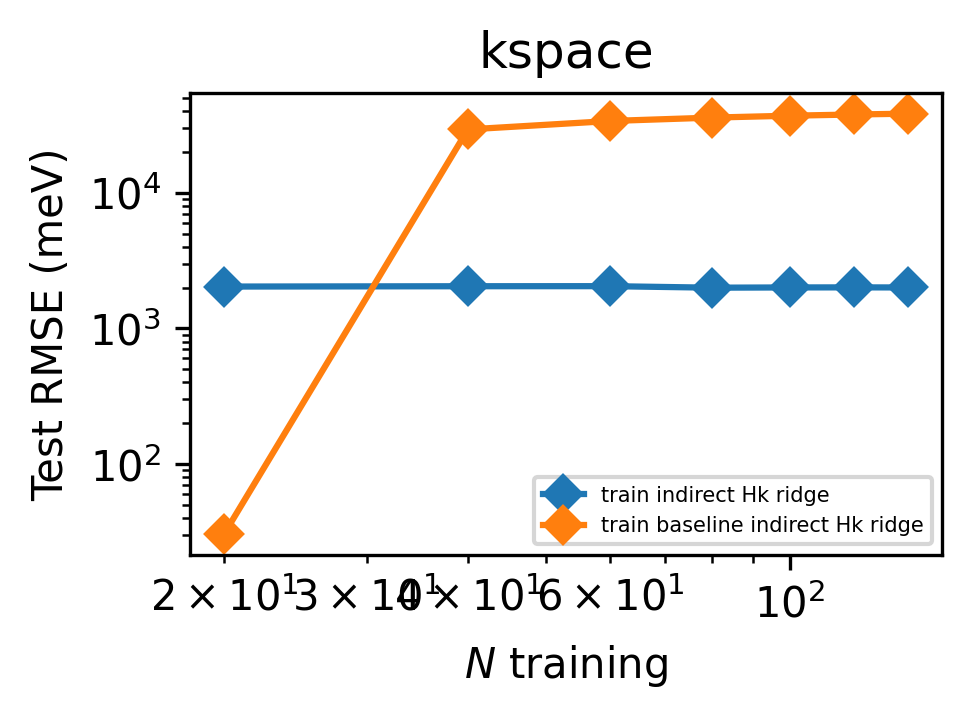

In [22]:
metrics_name = 'RMSE'
target_quantity = 'fock'
is_relative = False
from ase.units import Hartree

if metrics_name == 'RMSE':
    metrics = RMSE
    train_metrics = RMSE_train
elif metrics_name == 'MAE':
    metrics = MAE
    train_metrics = MAE_train

for space in ['kspace']:
    
    fig, ax = plt.subplots()
    
    
    for strategy in metrics[space]:
        if metrics[space][strategy] == {}:
            continue
        x = np.array([float(n) for n in metrics[space][strategy]])
        if is_relative:
            y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
            y_train = np.array([train_metrics[space][strategy][n][target_quantity]/STD_train[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
            unit = '%'
            lower = 1e-6
            upper = 1
        else:
            # y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
            y_train = np.array([train_metrics[space][strategy][n][target_quantity] for n in train_metrics[space][strategy]])*Hartree*1000
            unit = 'meV'
            lower = Hartree*1000
            upper = 10*Hartree*1000
        y = y[x.argsort()]
        y_train = y_train[x.argsort()]
        x = x[x.argsort()]
        # ax.plot(x, y, '-o', label = 'test ' + ' '.join(strategy.split("_")[1:]))
        ax.plot(x, y_train, '-D', label = 'train ' + ' '.join(strategy.split("_")[1:]))
    
    ax.legend(fontsize = 5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim(10, 170)
    # ax.set_ylim(2e-2, 2e-1)
    ax.set_xlabel('$N$ training')
    ax.set_title(space)
    ax.set_ylabel(f'Test {metrics_name} ({unit})')





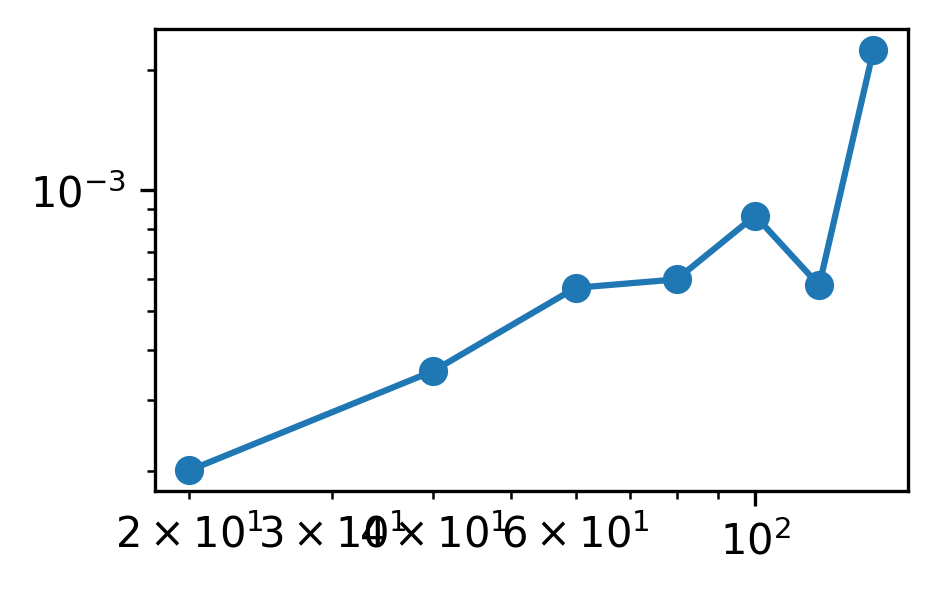

In [ ]:
x,y=np.loadtxt('/home/nigam/scratch/MAC/train_c2_174/seed_73/benchmarks/kspace/e_baseline_indirect_Hk_ridge/loss_per_structure.dat').T
plt.plot(x,y**0.5, '-o')
plt.xscale('log')
plt.yscale('log')

In [ ]:
metrics['kspace'].keys()

dict_keys(['d_indirect_Hk_ridge', 'e_baseline_indirect_Hk_ridge'])

In [ ]:
# ntrain = [20,40,60,80,100,120,140]
# pred_train = {}
# ridges = {}
# train_error = {'mae':{}, 'rmse':{}}
# test_error = {'mae':{}, 'rmse':{}}
# results_path = f'{root}/benchmarks/kspace/d_indirect_Hk_ridge'
# for trainsize in ntrain: 
#     ridges[trainsize] = np.load(f'{results_path}/ridges_bias_{trainsize}.npy', allow_pickle=True)
#     aa = load(f'{results_path}/pred_ridge_bias_real_{trainsize}')
#     bb = load(f'{results_path}/pred_ridge_bias_imag_{trainsize}')
#     blocks = []
#     for (k1, b1) in aa.items():
#         b2 = bb.block(k1)
#         assert b1.samples == b2.samples
#         blocks.append(TensorBlock(values = b1.values + 1j*b2.values, 
#                                 samples = b1.samples,
#                                 components = b1.components,
#                                 properties = b1.properties)
#                                 )
#     pred_train[trainsize] = TensorMap(aa.keys, blocks)
#     # train_error['mae'][trainsize] = mae_vector(train_targets[trainsize], pred_train[trainsize])
#     train_error['rmse'][trainsize] = L2_loss(train_targets_k[trainsize], pred_train[trainsize])
#     print(f'{trainsize} done')
    

20 done


AssertionError: Prediction and target must have the same samples

In [ ]:
from metatensor.torch import load   
aa = load('aa')
bb = load('bb')
blocks = []
for (k1, b1) in aa.items():
    b2 = bb.block(k1)
    assert b1.samples == b2.samples
    blocks.append(TensorBlock(values = b1.values + 1j*b2.values, 
                              samples = b1.samples,
                              components = b1.components,
                              properties = b1.properties)
                              )
tmap = TensorMap(aa.keys, blocks)